importing relevant libraries


In [1]:
# installing seaborn for data visualization
!pip install -q seaborn

In [2]:
!pip install -q tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.2 MB/s 


In [3]:
import tensorflow as tf
import math
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import os
import time
import matplotlib.pyplot as plt

from keras.losses import binary_crossentropy
from keras.layers import Dense, Flatten, Layer
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from keras.layers import Layer
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['figure.figsize'] =(10, 6)

defining the Radial Basis Function using keras backend

In [4]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Creating variables to store the datasets.

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [6]:
data_dir_1 = '/content/drive/MyDrive/kelmarsh_02.xlsx'
data_dir_2 = '/content/drive/MyDrive/kelmarsh_03.xlsx'
data_dir_3 = '/content/drive/MyDrive/kelmarsh_06.xlsx'
data_dir_4 = '/content/drive/MyDrive/penmanshiel_01.xlsx'
data_dir_5 = '/content/drive/MyDrive/penmanshiel_09.xlsx'
data_dir_6 = '/content/drive/MyDrive/penmanshiel_14.xlsx'

convert the excel files into a pandas array

In [7]:
data1 = pd.read_excel(data_dir_1)
data1.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,5.374402,113.313270,0.000000,386.335927
1,2020-01-01 00:10:00,4.777445,114.925915,0.000000,276.166611
2,2020-01-01 00:20:00,4.822455,117.427182,0.000000,243.963609
3,2020-01-01 00:30:00,3.570012,117.950283,0.296491,113.998529
4,2020-01-01 00:40:00,3.978185,115.878294,0.196997,150.627731


In [8]:
data1.describe()

,wind speed,wind direction,blade angle,power
count,51998.000000,52252.000000,51999.000000,52253.000000
mean,6.805167,198.266062,5.995527,786.264082
std,3.060756,90.886592,16.098587,700.807949
min,0.207534,0.008851,0.000000,-14.492521
25%,4.608004,146.114148,0.000000,172.394880
50%,6.491934,217.440111,0.049000,564.839690
75%,8.714540,258.723960,1.861500,1358.910526
max,24.102813,359.970279,92.650002,2081.149487


In [9]:
data1.isna().sum()

date                0
wind speed        706
wind direction    452
blade angle       705
power             451
dtype: int64

In [10]:
data2 = pd.read_excel(data_dir_2)
data2.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,4.778862,112.719236,0.295498,231.945189
1,2020-01-01 00:10:00,4.164535,111.551353,0.668000,140.533767
2,2020-01-01 00:20:00,3.924119,114.731451,1.013000,107.840487
3,2020-01-01 00:30:00,3.712292,105.735526,1.014500,98.657917
4,2020-01-01 00:40:00,3.620368,118.384276,1.055501,84.125479


In [11]:
data2.describe()

,wind speed,wind direction,blade angle,power
count,51956.000000,52210.000000,51955.000000,52209.000000
mean,6.415482,199.008896,8.016672,657.284536
std,2.927984,91.493962,19.293454,661.986076
min,0.000000,0.021386,0.000000,-14.172914
25%,4.313582,145.290044,0.000000,113.044590
50%,6.040477,220.727481,0.245998,407.915779
75%,8.134774,262.017976,2.237250,1065.056784
max,23.705931,359.983722,92.910588,2079.870593


In [12]:
data2.isna().sum()

date                0
wind speed        748
wind direction    494
blade angle       749
power             495
dtype: int64

In [13]:
data3 = pd.read_excel(data_dir_3)
data3.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,4.937197,114.420150,0.000000,281.981552
1,2020-01-01 00:10:00,4.149048,115.400679,0.278497,194.945205
2,2020-01-01 00:20:00,4.304425,111.796981,0.319499,180.241521
3,2020-01-01 00:30:00,3.540693,104.672035,0.990000,91.398078
4,2020-01-01 00:40:00,3.564476,112.202212,0.915500,98.042697


In [14]:
data3.describe()

,wind speed,wind direction,blade angle,power
count,51997.000000,52251.000000,51997.000000,52250.000000
mean,6.019222,197.688741,6.602770,604.866989
std,2.809434,92.057052,16.186250,632.956298
min,0.236618,0.036442,0.000000,-16.713042
25%,3.989365,144.530232,0.000000,102.838491
50%,5.637663,215.722711,0.258947,358.749105
75%,7.632658,257.584757,1.490000,938.947162
max,23.119149,359.995836,92.510002,2075.379227


In [15]:
data3.isna().sum()

date                0
wind speed        707
wind direction    453
blade angle       707
power             454
dtype: int64

In [16]:
data4 = pd.read_excel(data_dir_4)
data4.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,2.634660,239.849839,26.361820,-4.735457
1,2020-01-01 00:10:00,2.521986,219.579114,44.990002,-2.004182
2,2020-01-01 00:20:00,1.915439,235.777395,44.990002,-2.267019
3,2020-01-01 00:30:00,1.273258,252.689586,44.990002,-1.756993
4,2020-01-01 00:40:00,0.274278,103.131663,44.990002,-1.430491


In [17]:
data4.describe()

,wind speed,wind direction,blade angle,power
count,49417.000000,49604.000000,49416.000000,49603.000000
mean,7.838891,196.870397,9.244479,744.690993
std,4.365017,82.975135,18.441971,733.141519
min,0.166036,0.005882,-0.077000,-14.924585
25%,4.646741,151.430687,0.028333,94.447557
50%,6.889409,208.876307,0.904045,461.653972
75%,10.192620,253.424870,7.244550,1382.314983
max,25.644685,359.989002,92.589996,2076.726127


In [18]:
data4.isna().sum()

date                 0
wind speed        3287
wind direction    3100
blade angle       3288
power             3101
dtype: int64

In [19]:
data5 = pd.read_excel(data_dir_5)
data5.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,1.234190,206.832468,44.990002,-1.192550
1,2020-01-01 00:10:00,1.482292,197.361328,44.990002,-0.831904
2,2020-01-01 00:20:00,1.090630,194.204615,44.990002,-1.300317
3,2020-01-01 00:30:00,0.724122,197.456042,44.990002,-1.371451
4,2020-01-01 00:40:00,1.071950,203.071616,44.990002,-1.353312


In [20]:
data5.describe()

,wind speed,wind direction,blade angle,power
count,49819.000000,49981.000000,49818.000000,49979.000000
mean,6.895302,196.303697,11.138132,596.567639
std,3.943126,83.639652,20.312880,674.725123
min,0.198387,0.007225,-165.990362,-15.580938
25%,4.082113,152.007209,0.065667,40.442663
50%,6.079633,204.914069,0.972584,301.677136
75%,8.807622,255.117820,9.237092,981.529254
max,25.473274,359.993448,92.629997,2071.363053


In [21]:
data5.isna().sum()

date                 0
wind speed        2885
wind direction    2723
blade angle       2886
power             2725
dtype: int64

In [22]:
data6 = pd.read_excel(data_dir_6)
data6.head()

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 00:00:00,2.626171,231.491729,40.001395,-4.414605
1,2020-01-01 00:10:00,2.030696,227.152065,44.990002,-2.300808
2,2020-01-01 00:20:00,1.856505,220.739198,44.990002,-3.112439
3,2020-01-01 00:30:00,1.705174,226.472323,44.990002,-2.124041
4,2020-01-01 00:40:00,0.935252,214.629695,44.990002,-1.892147


In [23]:
data6.describe()

,wind speed,wind direction,blade angle,power
count,49731.000000,49881.000000,49730.000000,49881.000000
mean,7.930283,196.586347,9.093826,737.734028
std,4.485084,83.274563,18.285284,733.932593
min,0.000000,0.002312,0.000000,-16.762198
25%,4.693013,153.329449,0.033000,96.265678
50%,6.883342,208.376600,0.848711,447.166051
75%,10.113169,251.091884,7.420005,1350.784437
max,27.693860,359.998879,92.550003,2075.109896


In [24]:
data6.isna().sum()

date                 0
wind speed        2973
wind direction    2823
blade angle       2974
power             2823
dtype: int64

lets view the variation of wind speed with time, our idea was to select the most variant year.

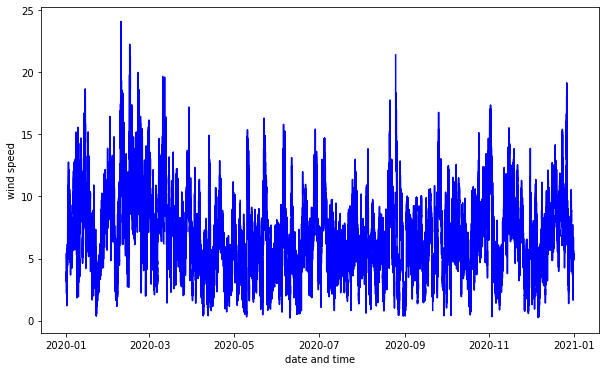

In [25]:
plt.plot(data1[['date']], data1[['wind speed']], color = 'b')
plt.xlabel("date and time")
plt.ylabel("wind speed")
plt.show()

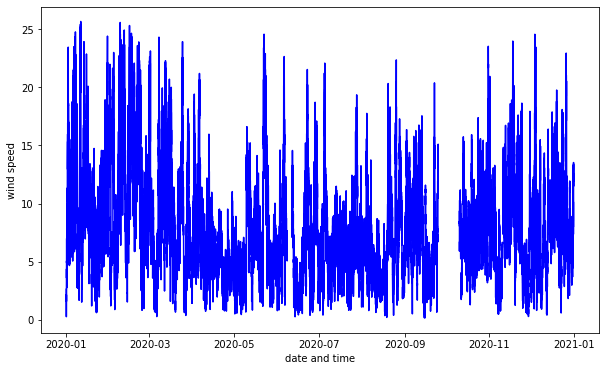

In [26]:
plt.plot(data4[['date']], data4[['wind speed']], color = 'b')
plt.xlabel("date and time")
plt.ylabel("wind speed")
plt.show()

Visualizing the power curve and the variation in wind speed with time for the data 

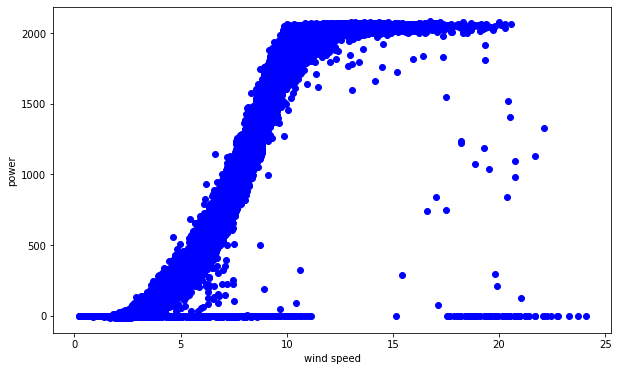

In [27]:
plt.scatter(data1[['wind speed']], data1[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

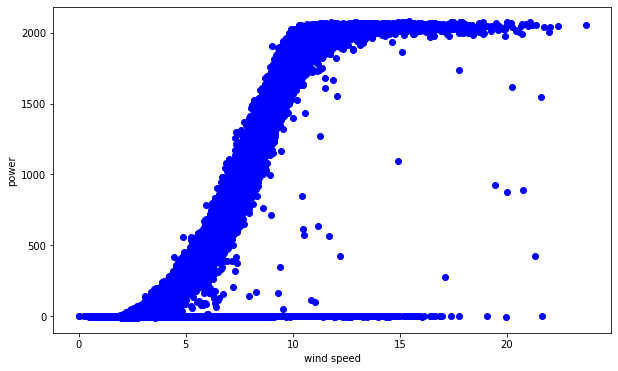

In [28]:
plt.scatter(data2[['wind speed']], data2[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

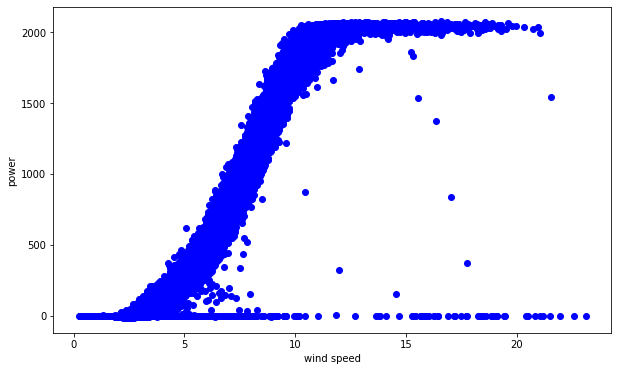

In [29]:
plt.scatter(data3[['wind speed']], data3[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

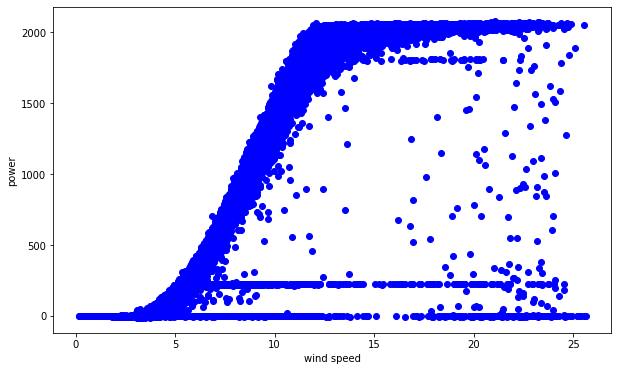

In [30]:
plt.scatter(data4[['wind speed']], data4[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

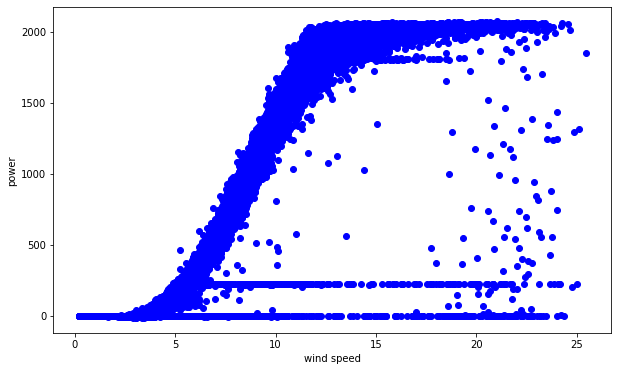

In [31]:
plt.scatter(data5[['wind speed']], data5[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

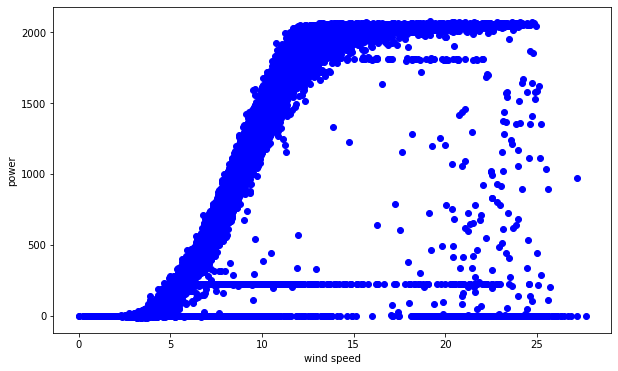

In [32]:
plt.scatter(data6[['wind speed']], data6[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

lets visualize all the parameters

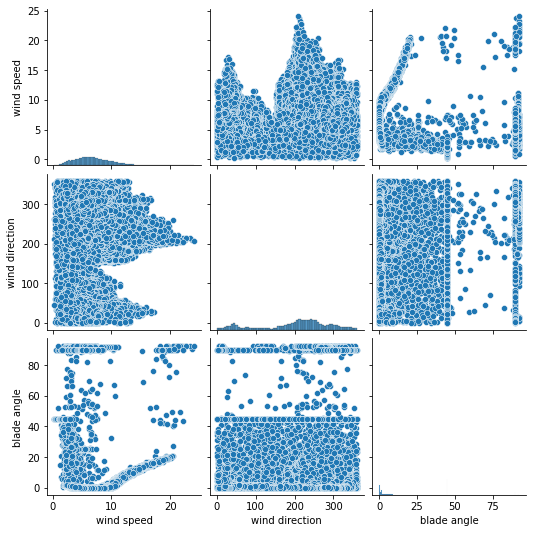

In [33]:
sns.pairplot(data1[['wind speed', 'wind direction', 'blade angle']], diag_kind ='hist')


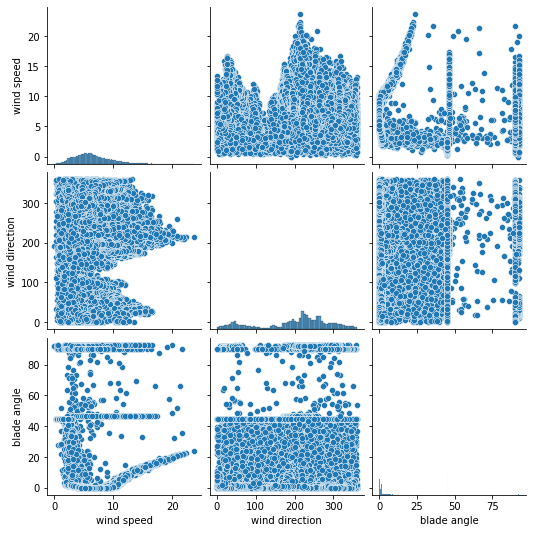

In [34]:
sns.pairplot(data2[['wind speed', 'wind direction', 'blade angle']], diag_kind = 'hist')

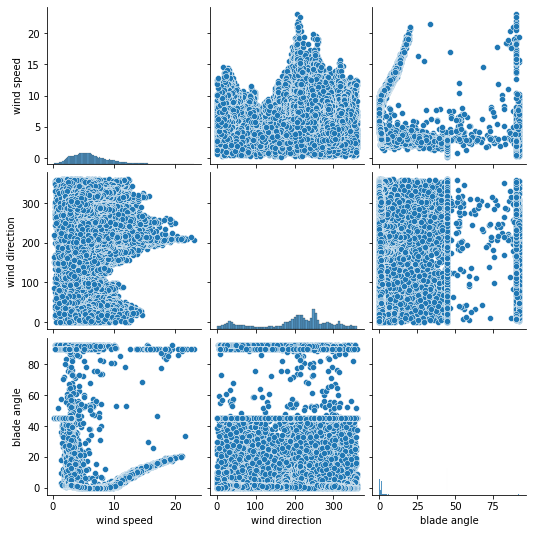

In [35]:
sns.pairplot(data3[['wind speed', 'wind direction', 'blade angle']], diag_kind = 'hist')

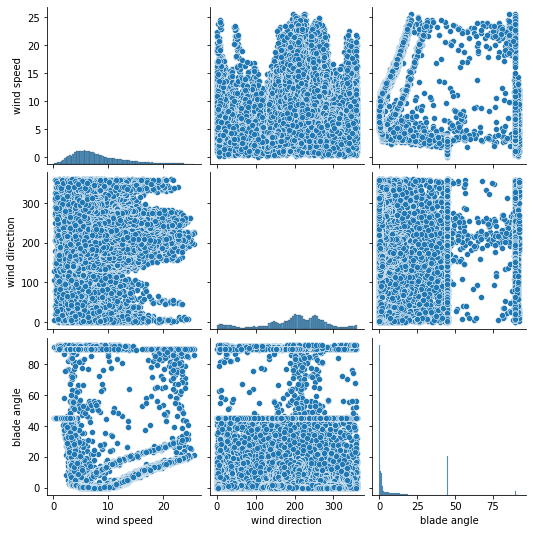

In [36]:
sns.pairplot(data4[['wind speed', 'wind direction', 'blade angle']], diag_kind = 'hist')

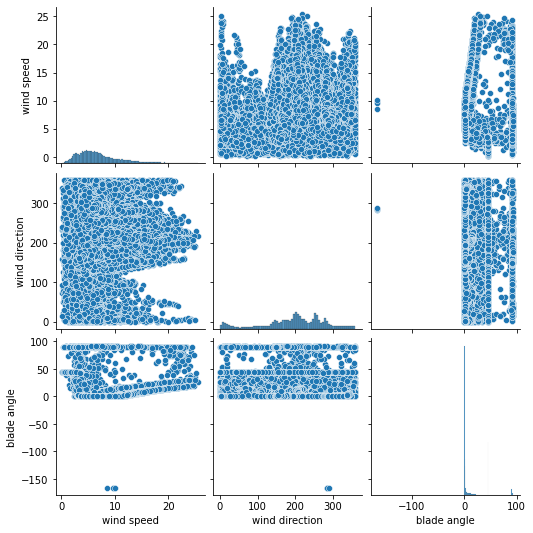

In [37]:
sns.pairplot(data5[['wind speed', 'wind direction', 'blade angle']], diag_kind = 'hist')

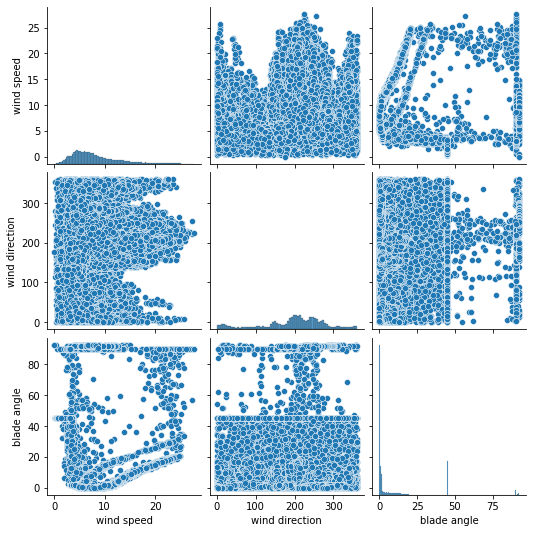

In [38]:
sns.pairplot(data6[['wind speed', 'wind direction', 'blade angle']], diag_kind = 'hist')

##DATA CLEANING AND FILTERING
for data cleaning, we employ the following;


*   Binning wind speed into 4 bins 
*   using confidence intervals to calculate datapoint maximum likelihood
*   replicating dataframe for each interval
*   combine dataframes together



In [39]:
data1.shape

(52704, 5)

In [40]:
def outlier_remover(dat, prop, min, max):
    d = dat
    q_low = d[prop].quantile(min)
    q_hi  = d[prop].quantile(max)
    return d[(d[prop] < q_hi) & (d[prop] > q_low)]

In [41]:
# Create Sub-DataFrames
d1 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d1[i] = data1.iloc[((data1['power']>=x)&((data1['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [42]:
d1[61] = data1.iloc[(data1['power']>=2900).values]

In [43]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.95
    elif ((x > 3) and (x <= 10)):
        F = 0.9
    elif ((x > 10) and (x <= 20)):
        F = 0.92
    elif ((x > 20) and (x < 30)):
        F = 0.96
    else:
        F = 0.985
    d1[x] = outlier_remover(d1[x], 'wind speed', 0.00001, F)

In [44]:
df1=pd.DataFrame()
for infile in range(1,62):
    data1 = d1[infile]
    df1=df1.append(data1,ignore_index=True)

In [45]:
df1.shape

(43425, 5)

In [46]:
df1.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 02:30:00,3.047361,145.961096,0.756470,67.026379
1,2020-01-01 02:50:00,2.652139,148.854743,0.992502,44.451465
2,2020-01-01 03:00:00,3.426296,140.052622,0.716998,69.235138
3,2020-01-01 03:10:00,2.766799,147.151105,1.265001,31.892004
4,2020-01-01 03:30:00,2.966572,144.887999,1.119001,39.594655
5,2020-01-01 03:50:00,2.168595,157.603686,1.240002,29.033340
6,2020-01-01 04:10:00,2.363378,160.769552,1.166009,29.549465
7,2020-01-01 04:30:00,3.098880,162.021613,0.616000,69.643309
8,2020-01-01 13:00:00,3.144260,216.636634,1.041005,41.339839
9,2020-01-01 14:20:00,3.331382,211.486422,1.015502,46.824575


In [47]:
df1.describe()

,wind speed,wind direction,blade angle,power
count,43425.000000,43425.000000,43425.000000,43425.000000
mean,7.313621,198.574053,1.357036,903.937999
std,2.761696,89.568075,3.060956,689.294782
min,2.168595,0.017274,0.000000,20.006176
25%,5.174883,157.339767,0.000000,284.304046
50%,6.912160,218.429886,0.011500,711.712967
75%,9.118302,256.663718,0.816104,1550.345517
max,18.301301,359.957659,53.274999,2081.149487


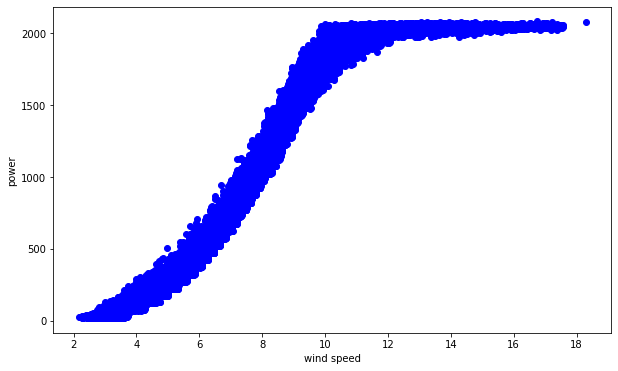

In [48]:
plt.scatter(df1[['wind speed']], df1[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

In [49]:
data2.shape

(52704, 5)

In [50]:
# Create Sub-DataFrames
d2 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d2[i] = data2.iloc[((data2['power']>=x)&((data2['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [51]:
d2[61] = data2.iloc[(data2['power']>=2900).values]

In [52]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.95
    elif ((x > 3) and (x <= 10)):
        F = 0.9
    elif ((x > 10) and (x <= 20)):
        F = 0.92
    elif ((x > 20) and (x < 30)):
        F = 0.96
    else:
        F = 0.985
    d2[x] = outlier_remover(d2[x], 'wind speed', 0.00001, F)

In [53]:
df2=pd.DataFrame()
for infile in range(1,62):
    data2 = d2[infile]
    df2=df2.append(data2,ignore_index=True)

In [54]:
df2.shape

(41196, 5)

In [55]:
df2.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 04:40:00,3.360784,159.870093,1.141008,67.770504
1,2020-01-01 04:50:00,3.195420,154.410149,1.466000,52.294904
2,2020-01-01 05:00:00,2.508917,162.892455,1.490000,28.681266
3,2020-01-01 06:00:00,3.318871,198.374087,1.315000,49.710954
4,2020-01-01 06:10:00,3.505874,202.329416,1.090002,68.824220
5,2020-01-01 06:50:00,3.273735,198.394429,1.267060,50.612432
6,2020-01-01 07:00:00,2.805655,211.792619,1.440000,34.671312
7,2020-01-01 07:40:00,3.005174,206.003871,1.490000,24.429679
8,2020-01-01 07:50:00,3.309396,207.231671,1.265003,42.503106
9,2020-01-01 08:00:00,2.994839,226.706911,1.390004,36.730840


In [56]:
df2.describe()

,wind speed,wind direction,blade angle,power
count,41196.000000,41196.000000,41196.000000,41196.000000
mean,6.915408,200.000077,1.251602,792.856169
std,2.656291,90.984188,2.916779,661.257042
min,2.228052,0.021386,0.000000,20.002572
25%,4.871767,153.624059,0.000000,230.742784
50%,6.410065,221.915340,0.098000,561.432062
75%,8.520782,261.580653,0.981007,1298.130342
max,20.180189,359.983722,64.710962,2079.870593


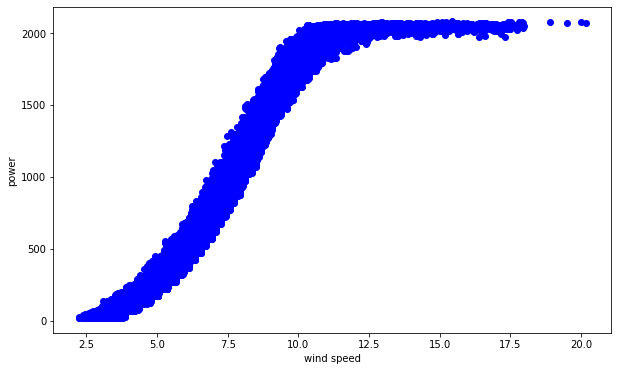

In [57]:
plt.scatter(df2[['wind speed']], df2[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

In [58]:
data3.shape

(52704, 5)

In [59]:
# Create Sub-DataFrames
d3 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d3[i] = data3.iloc[((data3['power']>=x)&((data3['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [60]:
d3[61] = data3.iloc[(data3['power']>=2900).values]

In [61]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.95
    elif ((x > 3) and (x <= 10)):
        F = 0.9
    elif ((x > 10) and (x <= 20)):
        F = 0.92
    elif ((x > 20) and (x < 30)):
        F = 0.96
    else:
        F = 0.985
    d3[x] = outlier_remover(d3[x], 'wind speed', 0.0001, F)

In [62]:
df3=pd.DataFrame()
for infile in range(1,62):
    data3 = d3[infile]
    df3=df3.append(data3,ignore_index=True)

In [63]:
df3.shape

(41278, 5)

In [64]:
df3.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 06:00:00,3.409746,194.196998,1.114999,66.112813
1,2020-01-01 07:30:00,3.350377,209.022406,1.239508,61.214499
2,2020-01-01 07:40:00,3.544212,207.756069,1.215002,53.772761
3,2020-01-01 07:50:00,3.257427,210.483009,1.365502,38.514273
4,2020-01-01 08:00:00,3.433508,219.774159,1.190001,68.817894
5,2020-01-01 14:30:00,3.414178,224.680570,1.340001,44.112111
6,2020-01-01 15:40:00,3.493907,227.217324,1.215002,63.779291
7,2020-01-01 17:00:00,3.456381,233.602425,1.335001,53.638312
8,2020-01-01 17:10:00,3.571828,225.106666,1.215506,68.679691
9,2020-01-03 23:00:00,3.427890,244.504516,1.212503,65.685542


In [65]:
df3.describe()

,wind speed,wind direction,blade angle,power
count,41278.000000,41278.000000,41278.000000,41278.000000
mean,6.631743,199.335747,1.102194,726.523884
std,2.544488,89.710605,2.701785,638.716423
min,2.361662,0.054923,0.000000,20.006491
25%,4.681070,160.127019,0.000000,203.079543
50%,6.099265,216.909937,0.116982,485.196473
75%,8.148329,255.737773,0.940500,1158.230753
max,18.156543,359.995836,61.344735,2075.379227


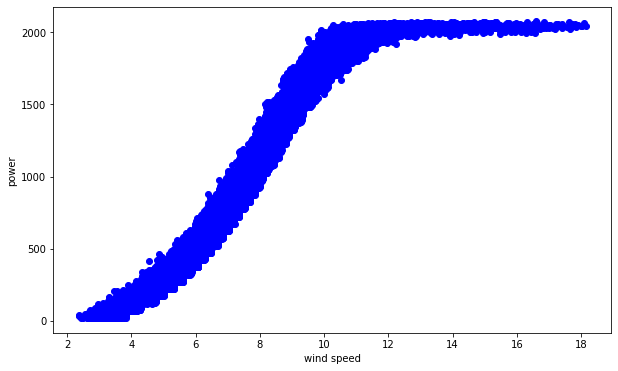

In [66]:
plt.scatter(df3[['wind speed']], df3[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

In [67]:
data4.shape

(52704, 5)

In [68]:
# Create Sub-DataFrames
d4 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d4[i] = data4.iloc[((data4['power']>=x)&((data4['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [69]:
d4[61] = data4.iloc[(data4['power']>=2900).values]

In [70]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.96
    elif ((x > 3) and (x <= 6)):
        F = 0.84
    elif ((x > 6) and (x <= 10)):
        F = 0.93
    elif ((x > 10) and (x <= 13)):
        F = 0.95
    elif ((x > 13) and (x <= 20)):
        F = 0.90
    elif ((x > 20) and (x < 30)):
        F = 0.88
    else:
        F = 0.9
    d4[x] = outlier_remover(d4[x], 'wind speed', 0.00001, F)

In [71]:
df4=pd.DataFrame()
for infile in range(1,62):
    data4 = d4[infile]
    df4=df4.append(data4,ignore_index=True)

In [72]:
df4.shape

(37247, 5)

In [73]:
df4.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 04:10:00,3.652382,191.274731,1.773668,23.588703
1,2020-01-01 04:30:00,4.005560,202.149163,1.556335,47.036562
2,2020-01-01 07:10:00,4.181386,237.305734,1.359341,69.551642
3,2020-01-01 07:50:00,4.154462,222.062451,1.319666,69.767560
4,2020-01-01 08:20:00,3.826013,226.014248,1.589999,38.981637
5,2020-01-01 08:30:00,3.863078,218.452789,1.640001,35.858054
6,2020-01-01 08:50:00,4.403107,222.775236,1.421334,61.315654
7,2020-01-01 09:30:00,3.956490,197.291479,1.556667,44.763081
8,2020-01-01 11:50:00,3.890779,208.682149,1.735001,22.401514
9,2020-01-08 19:50:00,4.288555,186.812644,6.625690,42.982359


In [74]:
df4.describe()

,wind speed,wind direction,blade angle,power
count,37247.000000,37247.000000,37247.000000,37247.000000
mean,8.488896,202.838084,1.976983,884.983350
std,3.724958,79.422575,3.657634,716.056599
min,3.108784,0.023003,-0.077000,20.001360
25%,5.553071,164.911131,0.000000,233.713658
50%,7.496976,212.224036,0.382258,651.498443
75%,10.736119,256.108932,1.617427,1604.091846
max,22.755679,359.947012,56.967585,2076.726127


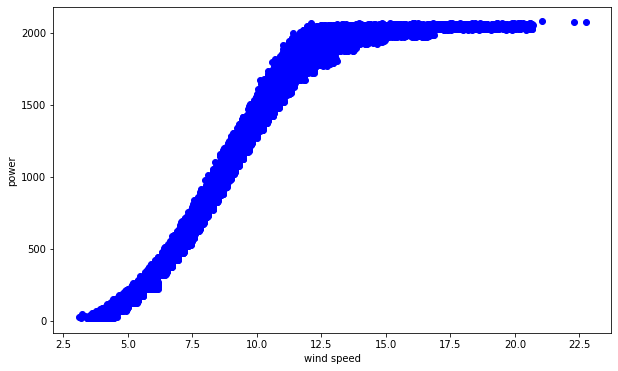

In [75]:
plt.scatter(df4[['wind speed']], df4[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

In [76]:
data5.shape

(52704, 5)

In [77]:
# Create Sub-DataFrames
d5 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d5[i] = data5.iloc[((data5['power']>=x)&((data5['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [78]:
d5[61] = data5.iloc[(data5['power']>=2900).values]

In [79]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.96
    elif ((x > 3) and (x <= 6)):
        F = 0.84
    elif ((x > 6) and (x <= 10)):
        F = 0.93
    elif ((x > 10) and (x <= 13)):
        F = 0.95
    elif ((x > 13) and (x <= 20)):
        F = 0.90
    elif ((x > 20) and (x < 30)):
        F = 0.88
    else:
        F = 0.9
    d5[x] = outlier_remover(d5[x], 'wind speed', 0.0001, F)

In [80]:
df5=pd.DataFrame()
for infile in range(1,62):
    data5 = d5[infile]
    df5=df5.append(data5,ignore_index=True)

In [81]:
df5.shape

(35282, 5)

In [82]:
df5.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 04:50:00,3.956012,193.694915,1.526339,46.153829
1,2020-01-01 05:20:00,3.921279,188.030905,1.656667,36.306291
2,2020-01-01 07:10:00,3.817780,226.340767,1.773001,27.443211
3,2020-01-01 07:20:00,3.813764,221.632984,1.758334,23.995908
4,2020-01-01 10:40:00,3.998509,203.055740,1.657007,39.328589
5,2020-01-01 12:00:00,3.942470,191.056717,33.265703,35.584617
6,2020-01-01 13:20:00,4.012990,228.290379,1.386672,67.800476
7,2020-01-01 14:30:00,3.821512,257.783232,1.757010,34.628113
8,2020-01-01 14:40:00,4.061699,236.225476,1.423672,59.861771
9,2020-01-03 01:20:00,4.219560,358.366893,1.490003,52.340328


In [83]:
df5.describe()

,wind speed,wind direction,blade angle,power
count,35282.000000,35282.000000,35282.000000,35282.000000
mean,7.766244,199.701130,1.643953,757.367187
std,3.343958,81.525544,3.392500,674.139500
min,3.117502,0.071217,-0.054828,20.002116
25%,5.186419,157.628841,0.016333,182.928852
50%,6.847368,206.469152,0.378000,501.324853
75%,9.533563,257.450591,1.440000,1278.948378
max,19.994984,359.952244,58.423108,2069.892897


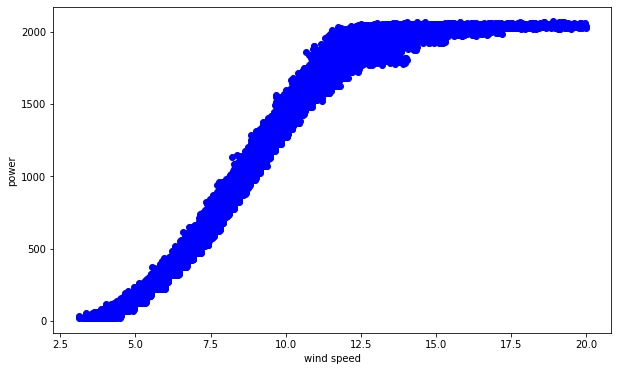

In [84]:
plt.scatter(df5[['wind speed']], df5[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

In [85]:
data6.shape

(52704, 5)

In [86]:
# Create Sub-DataFrames
d6 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d6[i] = data6.iloc[((data6['power']>=x)&((data6['power']<x+step))).values]
    #print(d[i])
    i = i + 1
print("There are in total of {} DataFrames".format(i-1))

There are in total of 62 DataFrames


In [87]:
d6[61] = data6.iloc[(data6['power']>=2900).values]

In [88]:
# Remove outlier
for x in range(1, 62):
    if x <= 3:
        F = 0.96
    elif ((x > 3) and (x <= 6)):
        F = 0.84
    elif ((x > 6) and (x <= 10)):
        F = 0.93
    elif ((x > 10) and (x <= 13)):
        F = 0.95
    elif ((x > 13) and (x <= 20)):
        F = 0.90
    elif ((x > 20) and (x < 30)):
        F = 0.88
    else:
        F = 0.9
    d6[x] = outlier_remover(d6[x], 'wind speed', 0.00001, F)

In [89]:
df6=pd.DataFrame()
for infile in range(1,62):
    data6 = d6[infile]
    df6=df6.append(data6,ignore_index=True)

In [90]:
df6.shape

(37760, 5)

In [91]:
df6.head(10)

,date,wind speed,wind direction,blade angle,power
0,2020-01-01 04:10:00,3.653289,198.199628,1.790000,24.679382
1,2020-01-01 04:30:00,3.882215,203.925515,1.689001,33.909854
2,2020-01-01 08:00:00,4.081861,243.257579,1.625666,40.157194
3,2020-01-01 08:20:00,4.015652,224.365395,1.553666,49.195612
4,2020-01-01 08:40:00,3.857329,219.892746,1.639333,34.181936
5,2020-01-01 08:50:00,3.822157,220.902864,1.707000,24.466143
6,2020-01-01 09:20:00,4.092296,202.721165,1.345999,67.715258
7,2020-01-03 09:20:00,4.032663,254.646716,1.632669,41.573772
8,2020-01-08 20:50:00,4.121746,201.068250,1.422334,58.870665
9,2020-01-08 23:10:00,3.870421,200.856201,1.519000,47.657210


In [92]:
df6.describe()

,wind speed,wind direction,blade angle,power
count,37760.000000,37760.000000,37760.000000,37760.000000
mean,8.449627,198.203173,2.059188,873.198708
std,3.798398,81.082254,3.817581,719.449067
min,3.013724,0.002312,0.000000,20.004356
25%,5.467239,157.897645,0.000000,222.918868
50%,7.411163,208.785973,0.391062,633.929288
75%,10.565326,251.243274,1.596922,1577.883031
max,23.623623,359.988687,59.734665,2075.109896


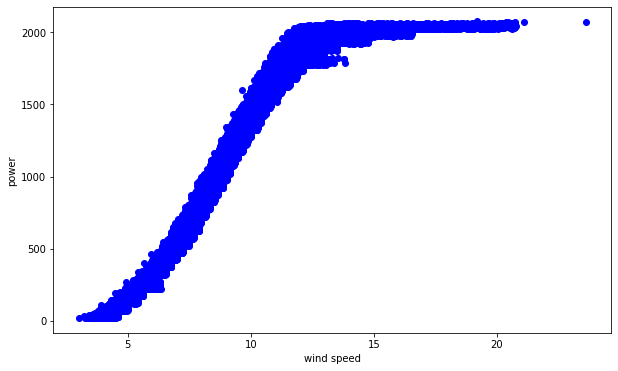

In [93]:
plt.scatter(df6[['wind speed']], df6[['power']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()

#standardization of dataset

In [94]:
da1 = df1.drop(columns=['date'])
da1.dropna()
scalar1 = MinMaxScaler(feature_range =(0, 1))
data1_ = scalar1.fit_transform(da1)
data1_X = data1_[:, :-1]
data1_Y = data1_[:, -1]
data1_X

array([[0.05447106, 0.40546665, 0.01419934],
       [0.02997288, 0.41350589, 0.01862979],
       [0.07795967, 0.3890515 , 0.01345843],
       ...,
       [0.71156922, 0.64352378, 0.22880338],
       [0.6695299 , 0.50817592, 0.17493196],
       [0.78289007, 0.62120033, 0.244458  ]])

In [95]:
data1_Y

array([0.02281268, 0.01186006, 0.0238843 , ..., 0.99662066, 0.99572944,
       0.99506547])

creating a training, test and validation dataset for **data1** divided (0.65, 0.2, 0.25)

In [96]:
x_train1_, x_test1, y_train1_, y_test1 = train_test_split(data1_X, data1_Y, test_size = 0.2, random_state = 1 )
x_train1, x_val1, y_train1, y_val1 =train_test_split(x_train1_, y_train1_, test_size = 0.25, random_state =2 )
x_val1

array([[6.68158835e-01, 6.42749254e-01, 1.67504845e-01],
       [3.25736820e-01, 5.67458985e-01, 0.00000000e+00],
       [2.99521353e-01, 1.11468586e-01, 0.00000000e+00],
       ...,
       [5.71048341e-01, 5.38681811e-01, 9.13374565e-02],
       [1.90201655e-01, 6.16343272e-01, 0.00000000e+00],
       [1.47134863e-01, 1.40232837e-01, 4.59873217e-04]])

In [97]:
da2 = df2.drop(columns=['date'])
da2.dropna()
scalar2 = MinMaxScaler(feature_range =(0, 1))
data2_ = scalar2.fit_transform(da2)
data2_X = data2_[:, :-1]
data2_Y = data2_[:, -1]
data2_X

array([[0.06309734, 0.44407064, 0.01763238],
       [0.05388596, 0.42890255, 0.02265459],
       [0.01564517, 0.45246697, 0.02302547],
       ...,
       [0.54261981, 0.70400223, 0.11666453],
       [0.67541091, 0.62726455, 0.18431962],
       [0.80194535, 0.5893659 , 0.22577319]])

In [98]:
data2_Y

array([0.0231898 , 0.01567689, 0.00421323, ..., 0.99594214, 0.99529709,
       0.99539768])

In [99]:
x_train2_, x_test2, y_train2_, y_test2 = train_test_split(data2_X, data2_Y, test_size = 0.2, random_state = 1 )
x_train2, x_val2, y_train2, y_val2 =train_test_split(x_train2_, y_train2_, test_size = 0.25, random_state =2 )
x_val2

array([[0.08931226, 0.71771891, 0.01138136],
       [0.57387012, 0.53783176, 0.12119327],
       [0.12173025, 0.69232536, 0.0068612 ],
       ...,
       [0.70013817, 0.64438137, 0.20581869],
       [0.24913454, 0.23472172, 0.        ],
       [0.21458609, 0.99097883, 0.        ]])

In [100]:
da3 = df3.drop(columns=['date'])
da3.dropna()
scalar3 = MinMaxScaler(feature_range =(0, 1))
data3_ = scalar3.fit_transform(da3)
data3_X = data3_[:, :-1]
data3_Y = data3_[:, -1]
data3_X

array([[0.06635596, 0.53937207, 0.01817596],
       [0.06259721, 0.58056052, 0.02020561],
       [0.0748692 , 0.57704234, 0.01980614],
       ...,
       [0.80050606, 0.70603718, 0.20996912],
       [0.82060838, 0.57042405, 0.21479431],
       [0.73277774, 0.56464266, 0.18698426]])

In [101]:
data3_Y

array([0.0224321 , 0.02004892, 0.01642829, ..., 0.99801866, 0.99793846,
       0.99743852])

In [102]:
x_train3_, x_test3, y_train3_, y_test3 = train_test_split(data3_X, data3_Y, test_size = 0.2, random_state = 1 )
x_train3, x_val3, y_train3, y_val3 =train_test_split(x_train3_, y_train3_, test_size = 0.25, random_state =2 )
x_val3

array([[4.95988172e-01, 6.15996318e-01, 4.64703936e-02],
       [2.48042125e-01, 7.42921065e-01, 0.00000000e+00],
       [2.17292388e-01, 5.26672387e-01, 0.00000000e+00],
       ...,
       [2.04801348e-01, 5.19077388e-01, 3.99378120e-04],
       [2.52664147e-01, 9.76045539e-02, 0.00000000e+00],
       [3.24458243e-01, 2.50109019e-01, 0.00000000e+00]])

In [103]:
da4 = df4.drop(columns=['date'])
da4.dropna()
scalar4 = MinMaxScaler(feature_range =(0, 1))
data4_ = scalar4.fit_transform(da4)
data4_X = data4_[:, :-1]
data4_Y = data4_[:, -1]
data4_X

array([[0.02766836, 0.53136696, 0.03244249],
       [0.04564465, 0.5615801 , 0.02863261],
       [0.05459393, 0.65925786, 0.02517927],
       ...,
       [0.91402968, 0.60048589, 0.29718528],
       [0.97534825, 0.59643918, 0.3127213 ],
       [1.        , 0.56439995, 0.31565953]])

In [104]:
data4_Y

array([0.0017442 , 0.01314478, 0.02409184, ..., 1.        , 0.99826265,
       0.99678315])

In [105]:
x_train4_, x_test4, y_train4_, y_test4 = train_test_split(data4_X, data4_Y, test_size = 0.2, random_state = 1 )
x_train4, x_val4, y_train4, y_val4 =train_test_split(x_train4_, y_train4_, test_size = 0.25, random_state =2 )
x_val4

array([[0.35827178, 0.5336349 , 0.00965327],
       [0.11337407, 0.42128474, 0.00134982],
       [0.15003795, 0.71906897, 0.00250681],
       ...,
       [0.04648771, 0.99193449, 0.02460649],
       [0.08530975, 0.53551296, 0.02133419],
       [0.16621778, 0.53148107, 0.00134982]])

In [106]:
da5 = df5.drop(columns=['date'])
da5.dropna()
scalar5 = MinMaxScaler(feature_range =(0, 1))
data5_ = scalar5.fit_transform(da5)
data5_X = data5_[:, :-1]
data5_Y = data5_[:, -1]
data5_X

array([[0.04968218, 0.53802141, 0.0270387 ],
       [0.04762426, 0.52228285, 0.02926736],
       [0.04149185, 0.62873431, 0.03125672],
       ...,
       [0.55450012, 0.93740124, 0.07740517],
       [0.54533003, 0.93559341, 0.0699645 ],
       [0.55552979, 0.93829231, 0.06448861]])

In [107]:
data5_Y

array([0.01275761, 0.00795368, 0.00363   , ..., 0.9864892 , 0.97691977,
       0.9808475 ])

In [108]:
x_train5_, x_test5, y_train5_, y_test5 = train_test_split(data5_X, data5_Y, test_size = 0.2, random_state = 1 )
x_train5, x_val5, y_train5, y_val5 =train_test_split(x_train5_, y_train5_, test_size = 0.25, random_state =2 )
x_val5

array([[0.33303197, 0.49409633, 0.00093758],
       [0.26284652, 0.61916323, 0.00093758],
       [0.58211863, 0.08008288, 0.07057068],
       ...,
       [0.2035533 , 0.67877706, 0.00093758],
       [0.17311178, 0.6817206 , 0.0054122 ],
       [0.15192124, 0.46563772, 0.00093758]])

In [109]:
da6 = df6.drop(columns=['date'])
da6.dropna()
scalar6 = MinMaxScaler(feature_range =(0, 1))
data6_ = scalar6.fit_transform(da6)
data6_X = data6_[:, :-1]
data6_Y = data6_[:, -1]
data6_X

array([[0.03103192, 0.55056894, 0.02996585],
       [0.04213952, 0.56647478, 0.02827505],
       [0.05182638, 0.67573465, 0.02721479],
       ...,
       [0.84242143, 0.55343623, 0.26869224],
       [1.        , 0.68937357, 0.31638871],
       [0.84652502, 0.53788221, 0.26897519]])

In [110]:
data6_Y

array([0.00227483, 0.00676632, 0.00980623, ..., 0.9991878 , 0.99976772,
       0.99952884])

In [111]:
x_train6_, x_test6, y_train6_, y_test6 = train_test_split(data6_X, data6_Y, test_size = 0.2, random_state = 1 )
x_train6, x_val6, y_train6, y_val6 =train_test_split(x_train6_, y_train6_, test_size = 0.25, random_state =2 )
x_val6

array([[0.21664842, 0.56200199, 0.        ],
       [0.6279879 , 0.58568582, 0.17740728],
       [0.22689036, 0.07750338, 0.        ],
       ...,
       [0.30361364, 0.40695855, 0.00103908],
       [0.71089802, 0.63722662, 0.19382439],
       [0.30218193, 0.77851622, 0.00154571]])

#MODEL DEVELOPMENT
Here we develop 3 regression models for comparison, we compare their accuracies using MAE, MSE and RMSE, we also compare the efficiency of various optmizers on each of the model, obtaining the most accurate. the sequence of procedures are as follows;
*   creating of the neural networks model
*   testing the model for each of the optimizers and obtaining the loss to      epoch graph and obtaining the most accurate for a specific model. 
*   obtaining the computation time for all the models/optimizer pair.
*  compare the accuracy of the best optimizers for all the models that have been selected.
*  compare the most accurate models with other models from literature and 

**the models to be tested**
*    single hidden layer RBF feed forward neural networks
*    basic MLP neural networks with 4 node input layer, two 64 node hidden layers, one 4 node hidden layer, one output layer.
*    4 node input layer, two 64 node hidden layer, one 1 node hidden layer, two 64 node hidden layer, one output layer

**optimizers to be used**
*   stochastic gradient descent
*   Adam 
*   RMsprop
*   

**activation functions**
*  sigmoid
*  relu

**accuracy metrics**
*   MSE
*   MAE
*   RMSE
*   R2

In [112]:
input_shape = x_train1.shape[1]
input_shape


3

In [113]:
y_train1.shape

(26055,)

**DESIGNATION**


model(dataset number)_(model number)(optimizer letter)

#RBF neural networks

**model1_1A**

adam

In [114]:


model1_1A = Sequential()
model1_1A.add(Dense(128, input_dim = (3)))
model1_1A.add(RBFLayer(64, 0.5))
model1_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model1_1A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 rbf_layer (RBFLayer)        (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


using adam optimizer

In [115]:

model1_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [116]:
start_time1_1A = time.time()
history1_1A = model1_1A.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_1A = time.time()

Epoch 1/50
522/522 [==============================] - 6s 6ms/step - loss: 0.4419 - root_mean_squared_error: 0.0998 - mean_absolute_error: 0.0549 - val_loss: 0.4230 - val_root_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.0258
Epoch 2/50
522/522 [==============================] - 3s 6ms/step - loss: 0.4181 - root_mean_squared_error: 0.0341 - mean_absolute_error: 0.0257 - val_loss: 0.4236 - val_root_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.0277
Epoch 3/50
522/522 [==============================] - 3s 5ms/step - loss: 0.4178 - root_mean_squared_error: 0.0332 - mean_absolute_error: 0.0251 - val_loss: 0.4231 - val_root_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.0263
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 0.4177 - root_mean_squared_error: 0.0331 - mean_absolute_error: 0.0249 - val_loss: 0.4225 - val_root_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.0243
Epoch 5/50
522/522 [==============================] - 3s

In [117]:
print("--- %s seconds ---" % (end_time1_1A - start_time1_1A))

--- 145.94839453697205 seconds ---


In [118]:
y_pred1_1A = model1_1A.predict(x_test1)
metric1_1A = r2_score(y_test1, y_pred1_1A)
metric1_1A

0.9924361998919675

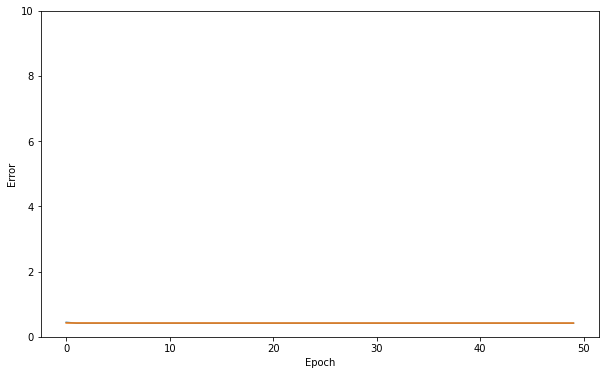

In [119]:
def plot_loss(history1_1A):
  plt.plot(history1_1A.history['loss'], label='loss')
  plt.plot(history1_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_1A)


**MODEL1_1B**

RMSPROP

In [120]:
model1_1B = Sequential()
model1_1B.add(Dense(128, input_dim = (3)))
model1_1B.add(RBFLayer(64, 0.5))
model1_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model1_1B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_1 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [121]:
model1_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError()
                       ])

In [122]:
start_time1_1B = time.time()
history1_1B = model1_1B.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_1B = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 0.4367 - root_mean_squared_error: 0.0888 - mean_absolute_error: 0.0510 - val_loss: 0.4263 - val_root_mean_squared_error: 0.0508 - val_mean_absolute_error: 0.0380
Epoch 2/50
522/522 [==============================] - 3s 6ms/step - loss: 0.4187 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0280 - val_loss: 0.4291 - val_root_mean_squared_error: 0.0564 - val_mean_absolute_error: 0.0449
Epoch 3/50
522/522 [==============================] - 3s 6ms/step - loss: 0.4183 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0270 - val_loss: 0.4226 - val_root_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.0245
Epoch 4/50
522/522 [==============================] - 3s 6ms/step - loss: 0.4181 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0264 - val_loss: 0.4297 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.0472
Epoch 5/50
522/522 [==============================] - 3s

In [123]:
print("--- %s seconds ---" % (end_time1_1B - start_time1_1B))

--- 202.69143509864807 seconds ---


In [124]:
y_pred1_1B = model1_1B.predict(x_test1)
metric1_1B = r2_score(y_test1, y_pred1_1B)
metric1_1B

0.9923952098392647

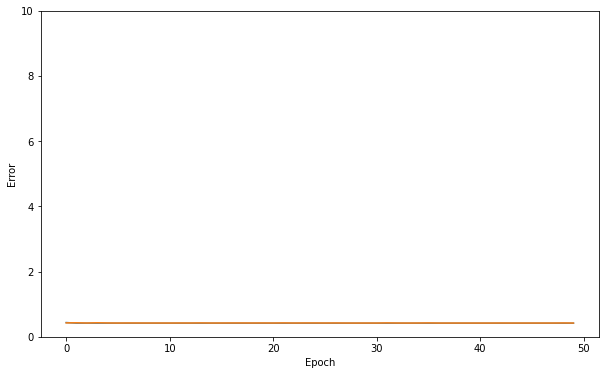

In [125]:
def plot_loss(history1_1B):
  plt.plot(history1_1B.history['loss'], label='loss')
  plt.plot(history1_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_1B)

**MODEL1_1C**

SGD

In [126]:
model1_1C = Sequential()
model1_1C.add(Dense(128, input_dim = (3)))
model1_1C.add(RBFLayer(64, 0.5))
model1_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model1_1C.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_2 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [127]:
model1_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [128]:
start_time1_1C = time.time()
history1_1C = model1_1C.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_1C = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 0.6590 - root_mean_squared_error: 0.3170 - mean_absolute_error: 0.2719 - val_loss: 0.6372 - val_root_mean_squared_error: 0.2973 - val_mean_absolute_error: 0.2546
Epoch 2/50
522/522 [==============================] - 3s 5ms/step - loss: 0.6137 - root_mean_squared_error: 0.2820 - mean_absolute_error: 0.2384 - val_loss: 0.5962 - val_root_mean_squared_error: 0.2642 - val_mean_absolute_error: 0.2221
Epoch 3/50
522/522 [==============================] - 3s 5ms/step - loss: 0.5703 - root_mean_squared_error: 0.2449 - mean_absolute_error: 0.2032 - val_loss: 0.5527 - val_root_mean_squared_error: 0.2239 - val_mean_absolute_error: 0.1855
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 0.5280 - root_mean_squared_error: 0.2034 - mean_absolute_error: 0.1650 - val_loss: 0.5136 - val_root_mean_squared_error: 0.1824 - val_mean_absolute_error: 0.1472
Epoch 5/50
522/522 [==============================] - 3s

In [129]:
print("--- %s seconds ---" % (end_time1_1C - start_time1_1C))

--- 142.50671553611755 seconds ---


In [130]:
y_pred1_1C = model1_1C.predict(x_test1)
metric1_1C = r2_score(y_test1, y_pred1_1C)
metric1_1C

0.9833333275711803

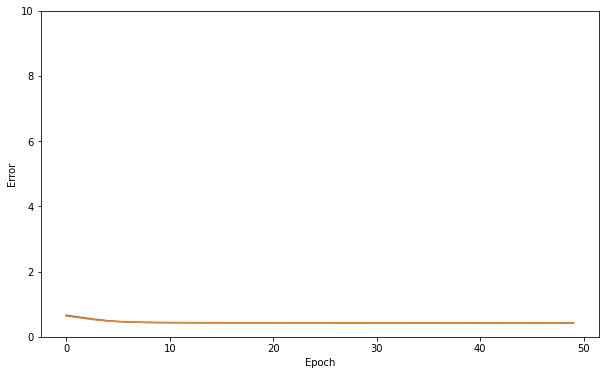

In [131]:
def plot_loss(history1_1C):
  plt.plot(history1_1C.history['loss'], label='loss')
  plt.plot(history1_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_1C)

**MODEL2_1A**

ADAM

In [132]:
model2_1A = Sequential()
model2_1A.add(Dense(128, input_dim = (3)))
model2_1A.add(RBFLayer(64, 0.5))
model2_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model2_1A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_3 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [133]:
model2_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [134]:
start_time2_1A = time.time()
history2_1A = model2_1A.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_1A = time.time()

Epoch 1/50
495/495 [==============================] - 3s 5ms/step - loss: 0.4712 - root_mean_squared_error: 0.1523 - mean_absolute_error: 0.0888 - val_loss: 0.4164 - val_root_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.0284
Epoch 2/50
495/495 [==============================] - 3s 6ms/step - loss: 0.4158 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0276 - val_loss: 0.4168 - val_root_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.0312
Epoch 3/50
495/495 [==============================] - 3s 5ms/step - loss: 0.4155 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0270 - val_loss: 0.4158 - val_root_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.0279
Epoch 4/50
495/495 [==============================] - 3s 6ms/step - loss: 0.4153 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0265 - val_loss: 0.4154 - val_root_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.0262
Epoch 5/50
495/495 [==============================] - 3s

In [135]:
print("--- %s seconds ---" % (end_time2_1A - start_time2_1A))

--- 133.99783611297607 seconds ---


In [136]:
y_pred2_1A = model2_1A.predict(x_test2)
metric2_1A = r2_score(y_test2, y_pred2_1A)
metric2_1A

0.9899964048625178

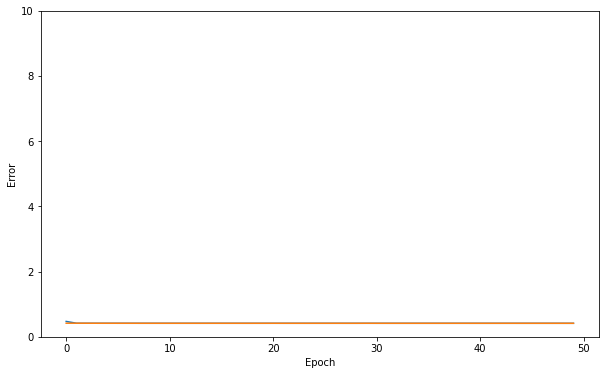

In [137]:
def plot_loss(history2_1A):
  plt.plot(history2_1A.history['loss'], label='loss')
  plt.plot(history2_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_1A)

**MODEL2_1B**

RMSPROP

In [138]:
model2_1B = Sequential()
model2_1B.add(Dense(128, input_dim = (3)))
model2_1B.add(RBFLayer(64, 0.5))
model2_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model2_1B.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_4 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [139]:
model2_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [140]:
start_time2_1B = time.time()
history2_1B = model2_1B.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_1B = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 0.4329 - root_mean_squared_error: 0.0865 - mean_absolute_error: 0.0508 - val_loss: 0.4162 - val_root_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.0281
Epoch 2/50
495/495 [==============================] - 3s 6ms/step - loss: 0.4165 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0300 - val_loss: 0.4159 - val_root_mean_squared_error: 0.0362 - val_mean_absolute_error: 0.0273
Epoch 3/50
495/495 [==============================] - 3s 5ms/step - loss: 0.4161 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0291 - val_loss: 0.4171 - val_root_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.0330
Epoch 4/50
495/495 [==============================] - 3s 5ms/step - loss: 0.4158 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0282 - val_loss: 0.4156 - val_root_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.0263
Epoch 5/50
495/495 [==============================] - 3s

In [141]:
print("--- %s seconds ---" % (end_time2_1B - start_time2_1B))

--- 142.962557554245 seconds ---


In [142]:
y_pred2_1B = model2_1B.predict(x_test2)
metric2_1B = r2_score(y_test2, y_pred2_1B)
metric2_1B

0.9896876777854399

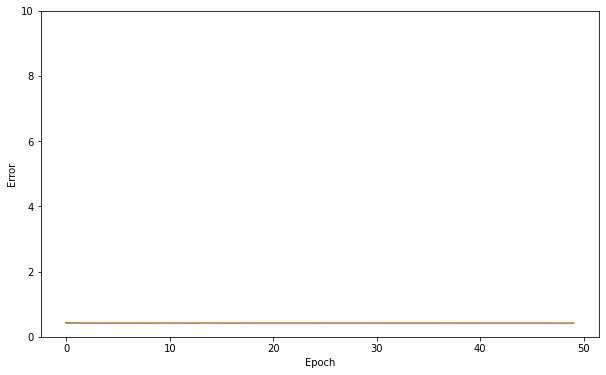

In [143]:
def plot_loss(history2_1B):
  plt.plot(history2_1B.history['loss'], label='loss')
  plt.plot(history2_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_1B)

**MODEL2_1C**

SGD

In [144]:
model2_1C = Sequential()
model2_1C.add(Dense(128, input_dim = (3)))
model2_1C.add(RBFLayer(64, 0.5))
model2_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model2_1C.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_5 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [145]:
model2_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [146]:
start_time2_1C = time.time()
history2_1C = model2_1C.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_1C = time.time()

Epoch 1/50
495/495 [==============================] - 3s 6ms/step - loss: 0.6296 - root_mean_squared_error: 0.2973 - mean_absolute_error: 0.2497 - val_loss: 0.6170 - val_root_mean_squared_error: 0.2880 - val_mean_absolute_error: 0.2379
Epoch 2/50
495/495 [==============================] - 2s 5ms/step - loss: 0.5993 - root_mean_squared_error: 0.2737 - mean_absolute_error: 0.2262 - val_loss: 0.5846 - val_root_mean_squared_error: 0.2614 - val_mean_absolute_error: 0.2141
Epoch 3/50
495/495 [==============================] - 2s 5ms/step - loss: 0.5654 - root_mean_squared_error: 0.2449 - mean_absolute_error: 0.1989 - val_loss: 0.5496 - val_root_mean_squared_error: 0.2302 - val_mean_absolute_error: 0.1851
Epoch 4/50
495/495 [==============================] - 3s 5ms/step - loss: 0.5311 - root_mean_squared_error: 0.2123 - mean_absolute_error: 0.1690 - val_loss: 0.5166 - val_root_mean_squared_error: 0.1969 - val_mean_absolute_error: 0.1547
Epoch 5/50
495/495 [==============================] - 2s

In [147]:
print("--- %s seconds ---" % (end_time2_1C - start_time2_1C))

--- 142.47984790802002 seconds ---


In [148]:
y_pred2_1C = model2_1C.predict(x_test2)
metric2_1C = r2_score(y_test2, y_pred2_1C)
metric2_1C

0.9789448254641796

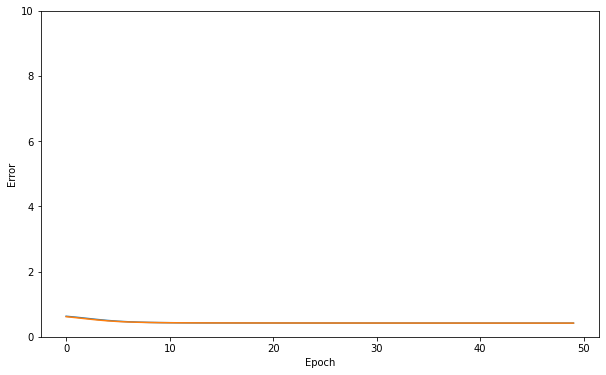

In [149]:
def plot_loss(history2_1C):
  plt.plot(history2_1C.history['loss'], label='loss')
  plt.plot(history2_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_1C)

**MODEL3_1A**

adam

In [150]:
model3_1A = Sequential()
model3_1A.add(Dense(128, input_dim = (3)))
model3_1A.add(RBFLayer(64, 0.5))
model3_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model3_1A.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_6 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [151]:
model3_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [152]:
start_time3_1A = time.time()
history3_1A = model3_1A.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_1A = time.time()

Epoch 1/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4343 - root_mean_squared_error: 0.0995 - mean_absolute_error: 0.0546 - val_loss: 0.4102 - val_root_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.0259
Epoch 2/50
496/496 [==============================] - 3s 5ms/step - loss: 0.4107 - root_mean_squared_error: 0.0336 - mean_absolute_error: 0.0254 - val_loss: 0.4098 - val_root_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.0250
Epoch 3/50
496/496 [==============================] - 3s 5ms/step - loss: 0.4104 - root_mean_squared_error: 0.0331 - mean_absolute_error: 0.0248 - val_loss: 0.4095 - val_root_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.0241
Epoch 4/50
496/496 [==============================] - 2s 5ms/step - loss: 0.4101 - root_mean_squared_error: 0.0323 - mean_absolute_error: 0.0240 - val_loss: 0.4094 - val_root_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.0238
Epoch 5/50
496/496 [==============================] - 3s

In [153]:
print("--- %s seconds ---" % (end_time3_1A - start_time3_1A))

--- 142.59497785568237 seconds ---


In [154]:
y_pred3_1A = model3_1A.predict(x_test3)
metric3_1A = r2_score(y_test3, y_pred3_1A)
metric3_1A

0.991727220927095

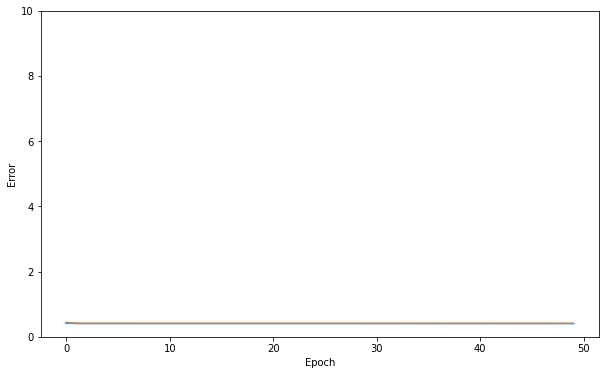

In [155]:
def plot_loss(history3_1A):
  plt.plot(history3_1A.history['loss'], label='loss')
  plt.plot(history3_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_1A)

**MODEL3_1B**

rmsprop

In [156]:
model3_1B = Sequential()
model3_1B.add(Dense(128, input_dim = (3)))
model3_1B.add(RBFLayer(64, 0.5))
model3_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model3_1B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_7 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [157]:
model3_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [158]:
start_time3_1B = time.time()
history3_1B = model3_1B.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_1B = time.time()

Epoch 1/50
496/496 [==============================] - 4s 6ms/step - loss: 0.4254 - root_mean_squared_error: 0.0795 - mean_absolute_error: 0.0466 - val_loss: 0.4104 - val_root_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.0273
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4114 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0280 - val_loss: 0.4100 - val_root_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.0262
Epoch 3/50
496/496 [==============================] - 3s 5ms/step - loss: 0.4110 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0271 - val_loss: 0.4117 - val_root_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.0306
Epoch 4/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4107 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0260 - val_loss: 0.4097 - val_root_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.0248
Epoch 5/50
496/496 [==============================] - 3s

In [159]:
print("--- %s seconds ---" % (end_time3_1B - start_time3_1B))

--- 142.475017786026 seconds ---


In [160]:
y_pred3_1B = model3_1B.predict(x_test3)
metric3_1B = r2_score(y_test3, y_pred3_1B)
metric3_1B

0.9912616365971377

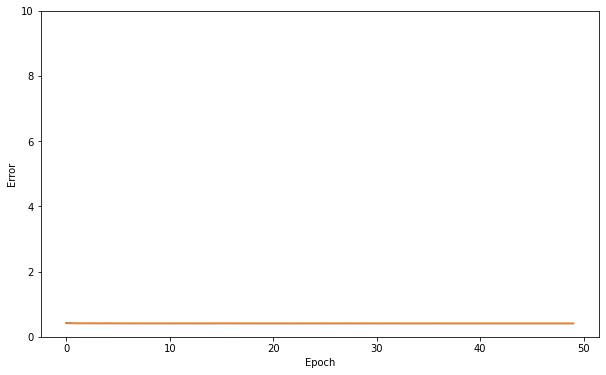

In [161]:
def plot_loss(history3_1B):
  plt.plot(history3_1B.history['loss'], label='loss')
  plt.plot(history3_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_1B)

**MODEL3_1C**

sgd

In [162]:
model3_1C = Sequential()
model3_1C.add(Dense(128, input_dim = (3)))
model3_1C.add(RBFLayer(64, 0.5))
model3_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model3_1C.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_8 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [163]:
model3_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [164]:
start_time3_1C = time.time()
history3_1C = model3_1C.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_1C = time.time()

Epoch 1/50
496/496 [==============================] - 3s 5ms/step - loss: 0.6140 - root_mean_squared_error: 0.2887 - mean_absolute_error: 0.2387 - val_loss: 0.5960 - val_root_mean_squared_error: 0.2756 - val_mean_absolute_error: 0.2224
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 0.5820 - root_mean_squared_error: 0.2638 - mean_absolute_error: 0.2125 - val_loss: 0.5635 - val_root_mean_squared_error: 0.2483 - val_mean_absolute_error: 0.1995
Epoch 3/50
496/496 [==============================] - 2s 5ms/step - loss: 0.5477 - root_mean_squared_error: 0.2342 - mean_absolute_error: 0.1847 - val_loss: 0.5280 - val_root_mean_squared_error: 0.2158 - val_mean_absolute_error: 0.1687
Epoch 4/50
496/496 [==============================] - 2s 5ms/step - loss: 0.5130 - root_mean_squared_error: 0.2001 - mean_absolute_error: 0.1539 - val_loss: 0.4952 - val_root_mean_squared_error: 0.1809 - val_mean_absolute_error: 0.1378
Epoch 5/50
496/496 [==============================] - 2s

In [165]:
print("--- %s seconds ---" % (end_time3_1C - start_time3_1C))

--- 142.5116708278656 seconds ---


In [166]:
y_pred3_1C = model3_1C.predict(x_test3)
metric3_1C = r2_score(y_test3, y_pred3_1C)
metric3_1C

0.9814718828739092

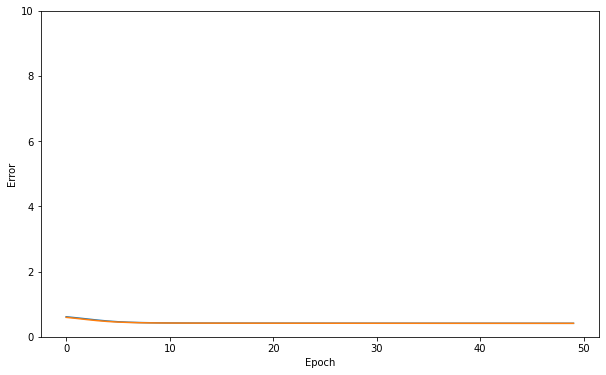

In [167]:
def plot_loss(history3_1C):
  plt.plot(history3_1C.history['loss'], label='loss')
  plt.plot(history3_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_1C)

**MODEL4_1A**

adam

In [168]:
model4_1A = Sequential()
model4_1A.add(Dense(128, input_dim = (3)))
model4_1A.add(RBFLayer(64, 0.5))
model4_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model4_1A.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               512       
                                                                 
 rbf_layer_9 (RBFLayer)      (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [169]:
model4_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [170]:
start_time4_1A = time.time()
history4_1A = model4_1A.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_1A = time.time()

Epoch 1/50
447/447 [==============================] - 3s 6ms/step - loss: 0.4126 - root_mean_squared_error: 0.0963 - mean_absolute_error: 0.0512 - val_loss: 0.3916 - val_root_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.0218
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 0.3888 - root_mean_squared_error: 0.0284 - mean_absolute_error: 0.0218 - val_loss: 0.3912 - val_root_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.0210
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 0.3886 - root_mean_squared_error: 0.0280 - mean_absolute_error: 0.0213 - val_loss: 0.3911 - val_root_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.0206
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 0.3884 - root_mean_squared_error: 0.0272 - mean_absolute_error: 0.0206 - val_loss: 0.3908 - val_root_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.0198
Epoch 5/50
447/447 [==============================] - 2s

In [171]:
print("--- %s seconds ---" % (end_time4_1A - start_time4_1A))

--- 114.99968314170837 seconds ---


In [172]:
y_pred4_1A = model4_1A.predict(x_test4)
metric4_1A = r2_score(y_test4, y_pred4_1A)
metric4_1A

0.995521409183197

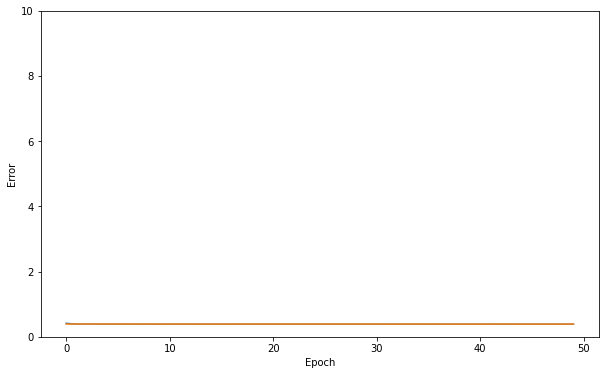

In [173]:
def plot_loss(history4_1A):
  plt.plot(history4_1A.history['loss'], label='loss')
  plt.plot(history4_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_1A)

**MODEL4_1B**

rmsprop

In [174]:
model4_1B = Sequential()
model4_1B.add(Dense(128, input_dim = (3)))
model4_1B.add(RBFLayer(64, 0.5))
model4_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model4_1B.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_10 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [175]:
model4_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [176]:
start_time4_1B = time.time()
history4_1B = model4_1B.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_1B = time.time()

Epoch 1/50
447/447 [==============================] - 3s 6ms/step - loss: 0.4085 - root_mean_squared_error: 0.0871 - mean_absolute_error: 0.0481 - val_loss: 0.3937 - val_root_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.0304
Epoch 2/50
447/447 [==============================] - 2s 6ms/step - loss: 0.3896 - root_mean_squared_error: 0.0330 - mean_absolute_error: 0.0249 - val_loss: 0.3922 - val_root_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.0254
Epoch 3/50
447/447 [==============================] - 2s 6ms/step - loss: 0.3893 - root_mean_squared_error: 0.0319 - mean_absolute_error: 0.0240 - val_loss: 0.3911 - val_root_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.0210
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 0.3890 - root_mean_squared_error: 0.0310 - mean_absolute_error: 0.0232 - val_loss: 0.3914 - val_root_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.0224
Epoch 5/50
447/447 [==============================] - 2s

In [177]:
print("--- %s seconds ---" % (end_time4_1B - start_time4_1B))

--- 124.43535661697388 seconds ---


In [178]:
y_pred4_1B = model4_1B.predict(x_test4)
metric4_1B = r2_score(y_test4, y_pred4_1B)
metric4_1B

0.9951840769267181

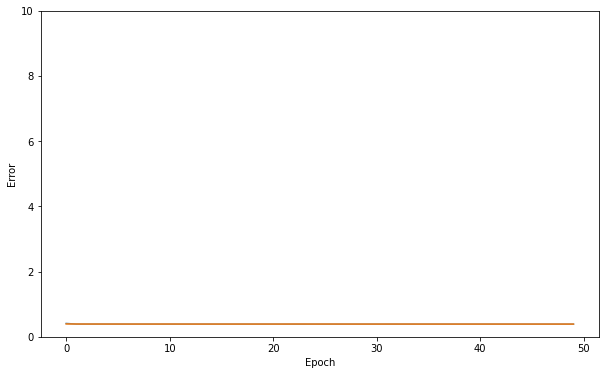

In [179]:
def plot_loss(history4_1B):
  plt.plot(history4_1B.history['loss'], label='loss')
  plt.plot(history4_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_1B)

**MODEL4_1C**

sgd

In [180]:
model4_1C = Sequential()
model4_1C.add(Dense(128, input_dim = (3)))
model4_1C.add(RBFLayer(64, 0.5))
model4_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model4_1C.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_11 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [181]:
model4_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [182]:
start_time4_1C = time.time()
history4_1C = model4_1C.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_1C = time.time()

Epoch 1/50
447/447 [==============================] - 3s 5ms/step - loss: 0.6564 - root_mean_squared_error: 0.3317 - mean_absolute_error: 0.2903 - val_loss: 0.6375 - val_root_mean_squared_error: 0.3161 - val_mean_absolute_error: 0.2758
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 0.6191 - root_mean_squared_error: 0.3041 - mean_absolute_error: 0.2630 - val_loss: 0.5988 - val_root_mean_squared_error: 0.2865 - val_mean_absolute_error: 0.2463
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 0.5769 - root_mean_squared_error: 0.2705 - mean_absolute_error: 0.2307 - val_loss: 0.5547 - val_root_mean_squared_error: 0.2489 - val_mean_absolute_error: 0.2119
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 0.5327 - root_mean_squared_error: 0.2310 - mean_absolute_error: 0.1942 - val_loss: 0.5127 - val_root_mean_squared_error: 0.2096 - val_mean_absolute_error: 0.1738
Epoch 5/50
447/447 [==============================] - 2s

In [183]:
print("--- %s seconds ---" % (end_time4_1C - start_time4_1C))

--- 111.95918488502502 seconds ---


In [184]:
y_pred4_1C = model4_1C.predict(x_test4)
metric4_1C = r2_score(y_test4, y_pred4_1C)
metric4_1C

0.9920978722113765

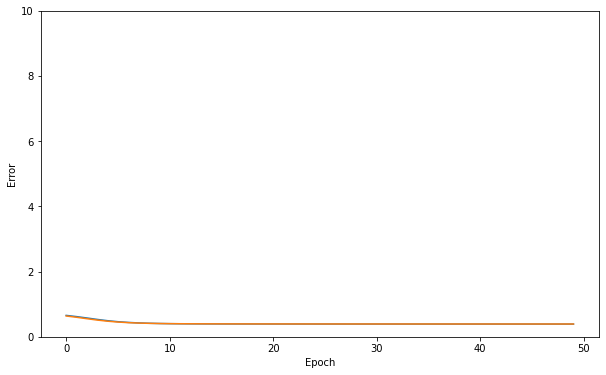

In [185]:
def plot_loss(history4_1C):
  plt.plot(history4_1C.history['loss'], label='loss')
  plt.plot(history4_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_1C)

**MODEL5_1A**

adam

In [186]:
model5_1A = Sequential()
model5_1A.add(Dense(128, input_dim = (3)))
model5_1A.add(RBFLayer(64, 0.5))
model5_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model5_1A.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_12 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [187]:
model5_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [188]:
start_time5_1A = time.time()
history5_1A = model5_1A.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_1A = time.time()

Epoch 1/50
424/424 [==============================] - 3s 6ms/step - loss: 0.4238 - root_mean_squared_error: 0.1127 - mean_absolute_error: 0.0607 - val_loss: 0.3921 - val_root_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.0266
Epoch 2/50
424/424 [==============================] - 2s 6ms/step - loss: 0.3915 - root_mean_squared_error: 0.0295 - mean_absolute_error: 0.0227 - val_loss: 0.3909 - val_root_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.0225
Epoch 3/50
424/424 [==============================] - 3s 6ms/step - loss: 0.3911 - root_mean_squared_error: 0.0286 - mean_absolute_error: 0.0217 - val_loss: 0.3908 - val_root_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.0222
Epoch 4/50
424/424 [==============================] - 2s 6ms/step - loss: 0.3908 - root_mean_squared_error: 0.0277 - mean_absolute_error: 0.0208 - val_loss: 0.3903 - val_root_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.0203
Epoch 5/50
424/424 [==============================] - 2s

In [189]:
print("--- %s seconds ---" % (end_time5_1A - start_time5_1A))

--- 142.571213722229 seconds ---


In [190]:
y_pred5_1A = model5_1A.predict(x_test5)
metric5_1A = r2_score(y_test5, y_pred5_1A)
metric5_1A

0.9950699924158273

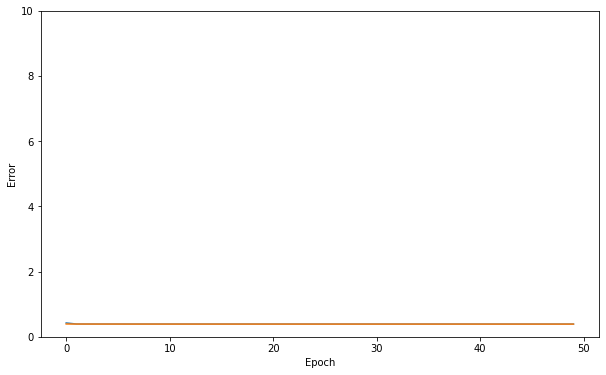

In [191]:
def plot_loss(history5_1A):
  plt.plot(history5_1A.history['loss'], label='loss')
  plt.plot(history5_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_1A)

**MODEL5_1B**

rmsprop

In [192]:
model5_1B = Sequential()
model5_1B.add(Dense(128, input_dim = (3)))
model5_1B.add(RBFLayer(64, 0.5))
model5_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model5_1B.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_13 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [193]:
model5_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [194]:
start_time5_1B = time.time()
history5_1B = model5_1B.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_1B = time.time()

Epoch 1/50
424/424 [==============================] - 4s 7ms/step - loss: 0.4110 - root_mean_squared_error: 0.0884 - mean_absolute_error: 0.0482 - val_loss: 0.3918 - val_root_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.0254
Epoch 2/50
424/424 [==============================] - 3s 6ms/step - loss: 0.3919 - root_mean_squared_error: 0.0327 - mean_absolute_error: 0.0246 - val_loss: 0.3906 - val_root_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.0211
Epoch 3/50
424/424 [==============================] - 2s 5ms/step - loss: 0.3914 - root_mean_squared_error: 0.0314 - mean_absolute_error: 0.0234 - val_loss: 0.3922 - val_root_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.0281
Epoch 4/50
424/424 [==============================] - 3s 6ms/step - loss: 0.3911 - root_mean_squared_error: 0.0304 - mean_absolute_error: 0.0225 - val_loss: 0.3902 - val_root_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.0203
Epoch 5/50
424/424 [==============================] - 2s

In [195]:
print("--- %s seconds ---" % (end_time5_1B - start_time5_1B))

--- 142.66327738761902 seconds ---


In [196]:
y_pred5_1B = model5_1B.predict(x_test5)
metric5_1B = r2_score(y_test5, y_pred5_1B)
metric5_1B

0.9933570925082352

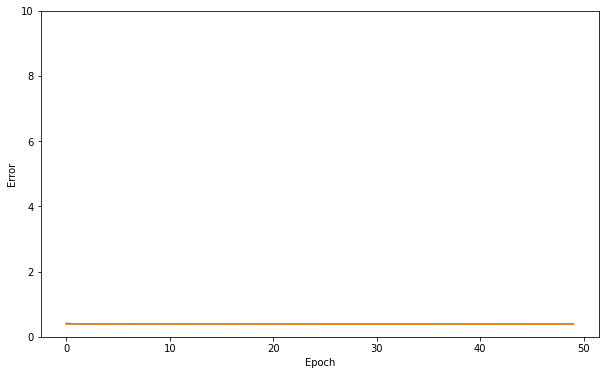

In [197]:
def plot_loss(history5_1B):
  plt.plot(history5_1B.history['loss'], label='loss')
  plt.plot(history5_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_1B)

**MODEL5_1C**

sgd

In [198]:
model5_1C = Sequential()
model5_1C.add(Dense(128, input_dim = (3)))
model5_1C.add(RBFLayer(64, 0.5))
model5_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model5_1C.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_14 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [199]:
model5_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [200]:
start_time5_1C = time.time()
history5_1C = model5_1C.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_1C = time.time()

Epoch 1/50
424/424 [==============================] - 3s 6ms/step - loss: 0.6161 - root_mean_squared_error: 0.3017 - mean_absolute_error: 0.2524 - val_loss: 0.5987 - val_root_mean_squared_error: 0.2896 - val_mean_absolute_error: 0.2384
Epoch 2/50
424/424 [==============================] - 2s 6ms/step - loss: 0.5733 - root_mean_squared_error: 0.2689 - mean_absolute_error: 0.2189 - val_loss: 0.5580 - val_root_mean_squared_error: 0.2579 - val_mean_absolute_error: 0.2061
Epoch 3/50
424/424 [==============================] - 2s 6ms/step - loss: 0.5334 - root_mean_squared_error: 0.2349 - mean_absolute_error: 0.1869 - val_loss: 0.5182 - val_root_mean_squared_error: 0.2220 - val_mean_absolute_error: 0.1739
Epoch 4/50
424/424 [==============================] - 2s 5ms/step - loss: 0.4973 - root_mean_squared_error: 0.1996 - mean_absolute_error: 0.1550 - val_loss: 0.4842 - val_root_mean_squared_error: 0.1861 - val_mean_absolute_error: 0.1433
Epoch 5/50
424/424 [==============================] - 2s

In [201]:
print("--- %s seconds ---" % (end_time5_1C - start_time5_1C))

--- 112.23185348510742 seconds ---


In [202]:
y_pred5_1C = model5_1C.predict(x_test5)
metric5_1C = r2_score(y_test5, y_pred5_1C)
metric5_1C

0.9880817322348995

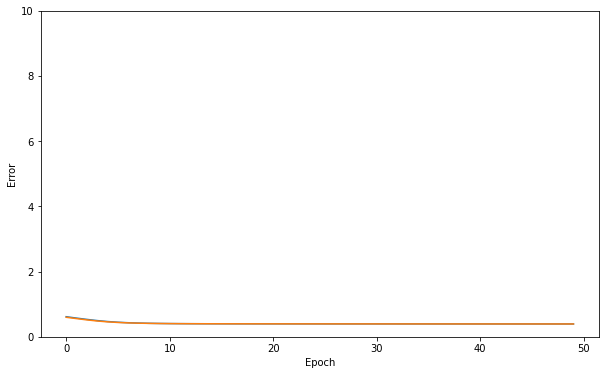

In [203]:
def plot_loss(history5_1C):
  plt.plot(history5_1C.history['loss'], label='loss')
  plt.plot(history5_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_1C)

**MODEL6_1A**

adam

In [204]:
model6_1A = Sequential()
model6_1A.add(Dense(128, input_dim = (3)))
model6_1A.add(RBFLayer(64, 0.5))
model6_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model6_1A.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_15 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [205]:
model6_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [206]:
start_time6_1A = time.time()
history6_1A = model6_1A.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_1A = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 0.4068 - root_mean_squared_error: 0.0960 - mean_absolute_error: 0.0517 - val_loss: 0.3813 - val_root_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.0228
Epoch 2/50
454/454 [==============================] - 3s 6ms/step - loss: 0.3828 - root_mean_squared_error: 0.0301 - mean_absolute_error: 0.0228 - val_loss: 0.3809 - val_root_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.0215
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3825 - root_mean_squared_error: 0.0291 - mean_absolute_error: 0.0219 - val_loss: 0.3816 - val_root_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.0250
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3823 - root_mean_squared_error: 0.0288 - mean_absolute_error: 0.0215 - val_loss: 0.3804 - val_root_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.0207
Epoch 5/50
454/454 [==============================] - 3s

In [207]:
print("--- %s seconds ---" % (end_time6_1A - start_time6_1A))

--- 142.56253147125244 seconds ---


In [208]:
y_pred6_1A = model6_1A.predict(x_test6)
metric6_1A = r2_score(y_test6, y_pred6_1A)
metric6_1A

0.9945651529325055

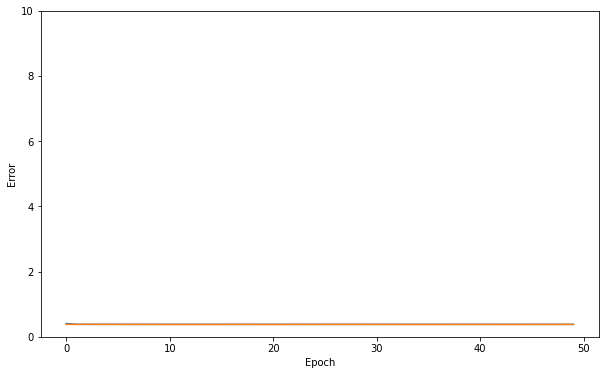

In [209]:
def plot_loss(history6_1A):
  plt.plot(history6_1A.history['loss'], label='loss')
  plt.plot(history6_1A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_1A)

**MODEL6_1B**

rmsprop

In [210]:
model6_1B = Sequential()
model6_1B.add(Dense(128, input_dim = (3)))
model6_1B.add(RBFLayer(64, 0.5))
model6_1B.add(Dense(1, activation='sigmoid', name= 'output'))
model6_1B.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_16 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [211]:
model6_1B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [212]:
start_time6_1B = time.time()
history6_1B = model6_1B.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_1B = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 0.4012 - root_mean_squared_error: 0.0841 - mean_absolute_error: 0.0473 - val_loss: 0.3812 - val_root_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.0227
Epoch 2/50
454/454 [==============================] - 3s 6ms/step - loss: 0.3835 - root_mean_squared_error: 0.0338 - mean_absolute_error: 0.0253 - val_loss: 0.3815 - val_root_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.0243
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3831 - root_mean_squared_error: 0.0326 - mean_absolute_error: 0.0241 - val_loss: 0.3849 - val_root_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.0369
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3828 - root_mean_squared_error: 0.0317 - mean_absolute_error: 0.0233 - val_loss: 0.3849 - val_root_mean_squared_error: 0.0498 - val_mean_absolute_error: 0.0375
Epoch 5/50
454/454 [==============================] - 3s

In [213]:
print("--- %s seconds ---" % (end_time6_1B - start_time6_1B))

--- 142.6765067577362 seconds ---


In [214]:
y_pred6_1B = model6_1B.predict(x_test6)
metric6_1B = r2_score(y_test6, y_pred6_1B)
metric6_1B

0.9948901187296019

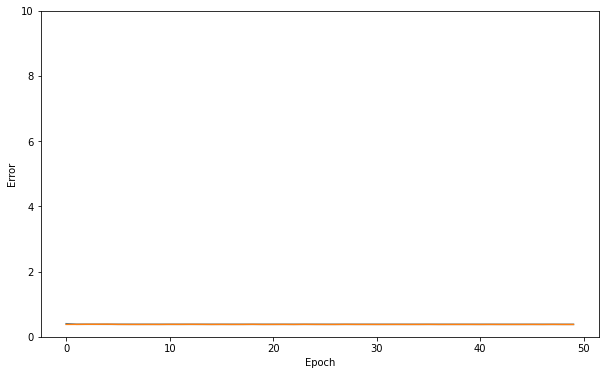

In [215]:
def plot_loss(history6_1B):
  plt.plot(history6_1B.history['loss'], label='loss')
  plt.plot(history6_1B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_1B)

**MODEL6_1C**

sgd

In [216]:
model6_1C = Sequential()
model6_1C.add(Dense(128, input_dim = (3)))
model6_1C.add(RBFLayer(64, 0.5))
model6_1C.add(Dense(1, activation='sigmoid', name= 'output'))
model6_1C.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               512       
                                                                 
 rbf_layer_17 (RBFLayer)     (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [217]:
model6_1C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [218]:
start_time6_1C = time.time()
history6_1C = model6_1C.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_1C = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 0.6441 - root_mean_squared_error: 0.3261 - mean_absolute_error: 0.2821 - val_loss: 0.6276 - val_root_mean_squared_error: 0.3154 - val_mean_absolute_error: 0.2694
Epoch 2/50
454/454 [==============================] - 3s 6ms/step - loss: 0.6072 - root_mean_squared_error: 0.2988 - mean_absolute_error: 0.2555 - val_loss: 0.5864 - val_root_mean_squared_error: 0.2835 - val_mean_absolute_error: 0.2410
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.5644 - root_mean_squared_error: 0.2643 - mean_absolute_error: 0.2229 - val_loss: 0.5418 - val_root_mean_squared_error: 0.2450 - val_mean_absolute_error: 0.2069
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.5212 - root_mean_squared_error: 0.2251 - mean_absolute_error: 0.1872 - val_loss: 0.5003 - val_root_mean_squared_error: 0.2055 - val_mean_absolute_error: 0.1698
Epoch 5/50
454/454 [==============================] - 2s

In [219]:
print("--- %s seconds ---" % (end_time6_1C - start_time6_1C))

--- 142.50738883018494 seconds ---


In [220]:
y_pred6_1C = model6_1C.predict(x_test6)
metric6_1C = r2_score(y_test6, y_pred6_1C)
metric6_1C

0.9911002027525703

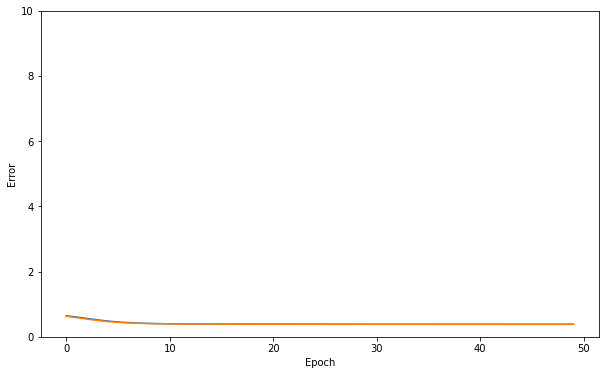

In [221]:
def plot_loss(history6_1C):
  plt.plot(history6_1C.history['loss'], label='loss')
  plt.plot(history6_1C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_1C)

#MODEL 2

In [222]:
model1_2A = Sequential()
model1_2A.add(Dense(3, activation='relu', input_dim=(3)))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(64, activation='relu'))
model1_2A.add(Dense(64, activation='relu'))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(1, name='output'))
model1_2A.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 3)                 12        
                                                                 
 dense_19 (Dense)            (None, 32)                128       
                                                                 
 dense_20 (Dense)            (None, 64)                2112      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [223]:
model1_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [224]:
start_time1_2A = time.time()
history1_2A = model1_2A.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_2A = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 0.4847 - root_mean_squared_error: 0.1552 - mean_absolute_error: 0.1081 - val_loss: 0.4480 - val_root_mean_squared_error: 0.0870 - val_mean_absolute_error: 0.0724
Epoch 2/50
522/522 [==============================] - 3s 5ms/step - loss: 0.4427 - root_mean_squared_error: 0.0915 - mean_absolute_error: 0.0557 - val_loss: 0.4408 - val_root_mean_squared_error: 0.0874 - val_mean_absolute_error: 0.0447
Epoch 3/50
522/522 [==============================] - 3s 5ms/step - loss: 0.4442 - root_mean_squared_error: 0.0974 - mean_absolute_error: 0.0573 - val_loss: 0.4391 - val_root_mean_squared_error: 0.0793 - val_mean_absolute_error: 0.0478
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 0.4389 - root_mean_squared_error: 0.0855 - mean_absolute_error: 0.0509 - val_loss: 0.4422 - val_root_mean_squared_error: 0.0852 - val_mean_absolute_error: 0.0425
Epoch 5/50
522/522 [==============================] - 3s

In [225]:
print("--- %s seconds ---" % (end_time1_2A - start_time1_2A))

--- 202.68003797531128 seconds ---


In [226]:
y_pred1_2A = model1_2A.predict(x_test1)
metric1_2A = r2_score(y_test1, y_pred1_2A)
metric1_2A

0.9932079998815817

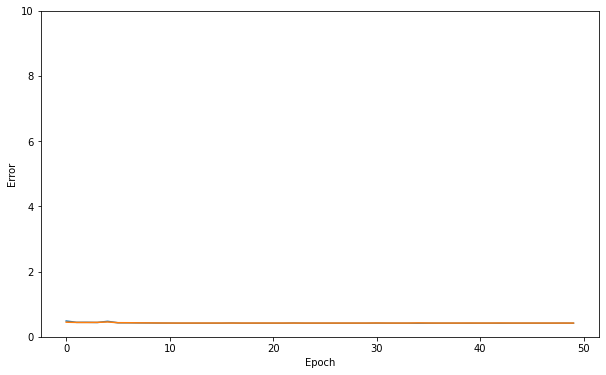

In [227]:
def plot_loss(history1_2A):
  plt.plot(history1_2A.history['loss'], label='loss')
  plt.plot(history1_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_2A)

**MODEL1_2B**

RMSPROP

In [228]:
model1_2B = Sequential()
model1_2B.add(Dense(3, activation='relu', input_dim=(3)))
model1_2B.add(Dense(32, activation='relu'))
model1_2B.add(Dense(64, activation='relu'))
model1_2B.add(Dense(64, activation='relu'))
model1_2B.add(Dense(32, activation='relu'))
model1_2B.add(Dense(1, name='output'))
model1_2B.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 3)                 12        
                                                                 
 dense_24 (Dense)            (None, 32)                128       
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [229]:
model1_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [230]:
start_time1_2B = time.time()
history1_2B = model1_2B.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_2B = time.time()

Epoch 1/50
522/522 [==============================] - 4s 7ms/step - loss: 6.6057 - root_mean_squared_error: 0.6063 - mean_absolute_error: 0.4978 - val_loss: 6.6638 - val_root_mean_squared_error: 0.6084 - val_mean_absolute_error: 0.5020
Epoch 2/50
522/522 [==============================] - 3s 7ms/step - loss: 6.6056 - root_mean_squared_error: 0.6063 - mean_absolute_error: 0.4978 - val_loss: 6.6638 - val_root_mean_squared_error: 0.6084 - val_mean_absolute_error: 0.5020
Epoch 3/50
522/522 [==============================] - 3s 6ms/step - loss: 6.6057 - root_mean_squared_error: 0.6063 - mean_absolute_error: 0.4978 - val_loss: 6.6638 - val_root_mean_squared_error: 0.6084 - val_mean_absolute_error: 0.5020
Epoch 4/50
522/522 [==============================] - 3s 6ms/step - loss: 6.6056 - root_mean_squared_error: 0.6063 - mean_absolute_error: 0.4978 - val_loss: 6.6638 - val_root_mean_squared_error: 0.6084 - val_mean_absolute_error: 0.5020
Epoch 5/50
522/522 [==============================] - 3s

In [231]:
print("--- %s seconds ---" % (end_time1_2B - start_time1_2B))

--- 166.04198622703552 seconds ---


In [232]:
y_pred1_2B = model1_2B.predict(x_test1)
metric1_2B = r2_score(y_test1, y_pred1_2B)
metric1_2B

-2.2444247758243034

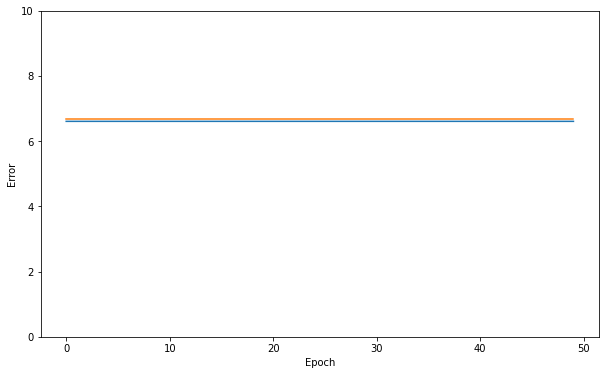

In [233]:
def plot_loss(history1_2B):
  plt.plot(history1_2B.history['loss'], label='loss')
  plt.plot(history1_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_2B)

**MODEL1_2C**

SGD

In [234]:
model1_2C = Sequential()
model1_2C.add(Dense(3, activation='relu', input_dim=(3)))
model1_2C.add(Dense(32, activation='relu'))
model1_2C.add(Dense(64, activation='relu'))
model1_2C.add(Dense(64, activation='relu'))
model1_2C.add(Dense(32, activation='relu'))
model1_2C.add(Dense(1, name='output'))
model1_2C.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 3)                 12        
                                                                 
 dense_29 (Dense)            (None, 32)                128       
                                                                 
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [235]:
model1_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [236]:
start_time1_2C = time.time()
history1_2C = model1_2C.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_2C = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 6.6056 - root_mean_squared_error: 0.5670 - mean_absolute_error: 0.4536 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5688 - val_mean_absolute_error: 0.4575
Epoch 2/50
522/522 [==============================] - 3s 5ms/step - loss: 6.6056 - root_mean_squared_error: 0.5670 - mean_absolute_error: 0.4536 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5688 - val_mean_absolute_error: 0.4575
Epoch 3/50
522/522 [==============================] - 3s 5ms/step - loss: 6.6056 - root_mean_squared_error: 0.5670 - mean_absolute_error: 0.4536 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5688 - val_mean_absolute_error: 0.4575
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 6.6056 - root_mean_squared_error: 0.5670 - mean_absolute_error: 0.4536 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5688 - val_mean_absolute_error: 0.4575
Epoch 5/50
522/522 [==============================] - 3s

In [237]:
print("--- %s seconds ---" % (end_time1_2C - start_time1_2C))

--- 140.15755105018616 seconds ---


In [238]:
y_pred1_2C = model1_2C.predict(x_test1)
metric1_2C = r2_score(y_test1, y_pred1_2C)
metric1_2C

-1.8431455597924025

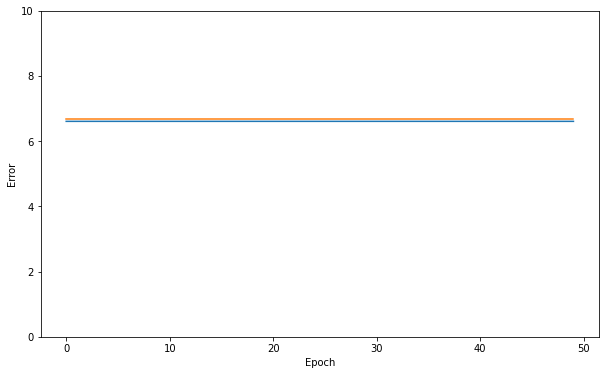

In [239]:
def plot_loss(history1_2C):
  plt.plot(history1_2C.history['loss'], label='loss')
  plt.plot(history1_2C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_2C)

**MODEL2_2A**

ADAM

In [240]:
model2_2A = Sequential()
model2_2A.add(Dense(3, activation='relu', input_dim=(3)))
model2_2A.add(Dense(32, activation='relu'))
model2_2A.add(Dense(64, activation='relu'))
model2_2A.add(Dense(64, activation='relu'))
model2_2A.add(Dense(32, activation='relu'))
model2_2A.add(Dense(1, name='output'))
model2_2A.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 3)                 12        
                                                                 
 dense_34 (Dense)            (None, 32)                128       
                                                                 
 dense_35 (Dense)            (None, 64)                2112      
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [241]:
model2_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [242]:
start_time2_2A = time.time()
history2_2A = model2_2A.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_2A = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 0.5777 - root_mean_squared_error: 0.2433 - mean_absolute_error: 0.1799 - val_loss: 0.4445 - val_root_mean_squared_error: 0.1026 - val_mean_absolute_error: 0.0744
Epoch 2/50
495/495 [==============================] - 3s 5ms/step - loss: 0.4228 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0402 - val_loss: 0.4146 - val_root_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.0239
Epoch 3/50
495/495 [==============================] - 3s 6ms/step - loss: 0.4146 - root_mean_squared_error: 0.0331 - mean_absolute_error: 0.0243 - val_loss: 0.4144 - val_root_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.0235
Epoch 4/50
495/495 [==============================] - 3s 6ms/step - loss: 0.4147 - root_mean_squared_error: 0.0331 - mean_absolute_error: 0.0245 - val_loss: 0.4155 - val_root_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.0261
Epoch 5/50
495/495 [==============================] - 3s

In [243]:
print("--- %s seconds ---" % (end_time2_2A - start_time2_2A))

--- 142.67061305046082 seconds ---


In [244]:
y_pred2_2A = model2_2A.predict(x_test2)
metric2_2A = r2_score(y_test2, y_pred2_2A)
metric2_2A

0.9902117638689739

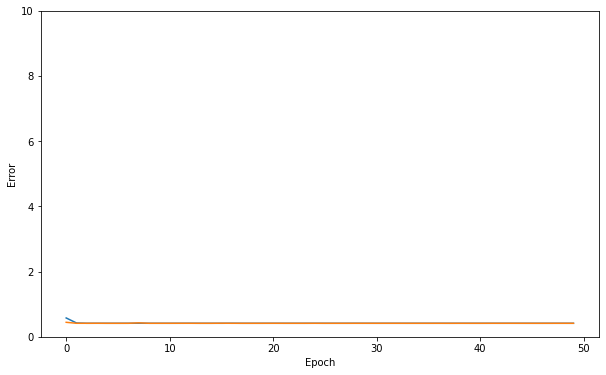

In [245]:
def plot_loss(history2_2A):
  plt.plot(history2_2A.history['loss'], label='loss')
  plt.plot(history2_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_2A)

**MODEL2_2B**

RMSPROP

In [246]:
model2_2B = Sequential()
model2_2B.add(Dense(3, activation='relu', input_dim=(3)))
model2_2B.add(Dense(32, activation='relu'))
model2_2B.add(Dense(64, activation='relu'))
model2_2B.add(Dense(64, activation='relu'))
model2_2B.add(Dense(32, activation='relu'))
model2_2B.add(Dense(1, name='output'))
model2_2B.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 3)                 12        
                                                                 
 dense_39 (Dense)            (None, 32)                128       
                                                                 
 dense_40 (Dense)            (None, 64)                2112      
                                                                 
 dense_41 (Dense)            (None, 64)                4160      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [247]:
model2_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [248]:
start_time2_2B = time.time()
history2_2B = model2_2B.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_2B = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.4992 - mean_absolute_error: 0.3797 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5018 - val_mean_absolute_error: 0.3825
Epoch 2/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.4992 - mean_absolute_error: 0.3797 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5018 - val_mean_absolute_error: 0.3825
Epoch 3/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.4992 - mean_absolute_error: 0.3797 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5018 - val_mean_absolute_error: 0.3825
Epoch 4/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.4992 - mean_absolute_error: 0.3797 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5018 - val_mean_absolute_error: 0.3825
Epoch 5/50
495/495 [==============================] - 3s

In [249]:
print("--- %s seconds ---" % (end_time2_2B - start_time2_2B))

--- 202.95468616485596 seconds ---


In [250]:
y_pred2_2B = model2_2B.predict(x_test2)
metric2_2B = r2_score(y_test2, y_pred2_2B)
metric2_2B

-1.406206055616538

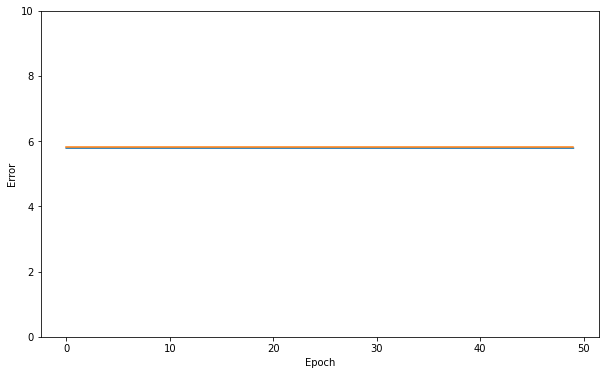

In [251]:
def plot_loss(history2_2B):
  plt.plot(history2_2B.history['loss'], label='loss')
  plt.plot(history2_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_2B)

**MODEL2_2C**

SGD

In [252]:
model2_2C = Sequential()
model2_2C.add(Dense(3, activation='relu', input_dim=(3)))
model2_2C.add(Dense(32, activation='relu'))
model2_2C.add(Dense(64, activation='relu'))
model2_2C.add(Dense(64, activation='relu'))
model2_2C.add(Dense(32, activation='relu'))
model2_2C.add(Dense(1, name='output'))
model2_2C.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_43 (Dense)            (None, 3)                 12        
                                                                 
 dense_44 (Dense)            (None, 32)                128       
                                                                 
 dense_45 (Dense)            (None, 64)                2112      
                                                                 
 dense_46 (Dense)            (None, 64)                4160      
                                                                 
 dense_47 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [253]:
model2_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [254]:
start_time2_2C = time.time()
history2_2C = model2_2C.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_2C = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 0.5939 - root_mean_squared_error: 0.2620 - mean_absolute_error: 0.2166 - val_loss: 0.4639 - val_root_mean_squared_error: 0.1311 - val_mean_absolute_error: 0.1021
Epoch 2/50
495/495 [==============================] - 3s 6ms/step - loss: 1.7175 - root_mean_squared_error: 0.5109 - mean_absolute_error: 0.2812 - val_loss: 5.8263 - val_root_mean_squared_error: 1.0391 - val_mean_absolute_error: 0.9886
Epoch 3/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 1.0363 - mean_absolute_error: 0.9859 - val_loss: 5.8263 - val_root_mean_squared_error: 1.0391 - val_mean_absolute_error: 0.9886
Epoch 4/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 1.0363 - mean_absolute_error: 0.9859 - val_loss: 5.8263 - val_root_mean_squared_error: 1.0391 - val_mean_absolute_error: 0.9886
Epoch 5/50
495/495 [==============================] - 3s

In [255]:
print("--- %s seconds ---" % (end_time2_2C - start_time2_2C))

--- 143.10375547409058 seconds ---


In [256]:
y_pred2_2C = model2_2C.predict(x_test2)
metric2_2C = r2_score(y_test2, y_pred2_2C)
metric2_2C

-9.396343965344013

**MODEL3_2A**

adam

In [257]:
model3_2A = Sequential()
model3_2A.add(Dense(3, activation='relu', input_dim=(3)))
model3_2A.add(Dense(32, activation='relu'))
model3_2A.add(Dense(64, activation='relu'))
model3_2A.add(Dense(64, activation='relu'))
model3_2A.add(Dense(32, activation='relu'))
model3_2A.add(Dense(1, name='output'))
model3_2A.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 3)                 12        
                                                                 
 dense_49 (Dense)            (None, 32)                128       
                                                                 
 dense_50 (Dense)            (None, 64)                2112      
                                                                 
 dense_51 (Dense)            (None, 64)                4160      
                                                                 
 dense_52 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [258]:
model3_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [259]:
start_time3_2A = time.time()
history3_2A = model3_2A.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_2A = time.time()

Epoch 1/50
496/496 [==============================] - 4s 6ms/step - loss: 0.5330 - root_mean_squared_error: 0.2049 - mean_absolute_error: 0.1395 - val_loss: 0.4253 - val_root_mean_squared_error: 0.0772 - val_mean_absolute_error: 0.0450
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4258 - root_mean_squared_error: 0.0723 - mean_absolute_error: 0.0443 - val_loss: 0.4216 - val_root_mean_squared_error: 0.0656 - val_mean_absolute_error: 0.0378
Epoch 3/50
496/496 [==============================] - 3s 5ms/step - loss: 0.4249 - root_mean_squared_error: 0.0702 - mean_absolute_error: 0.0441 - val_loss: 0.4232 - val_root_mean_squared_error: 0.0642 - val_mean_absolute_error: 0.0493
Epoch 4/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4515 - root_mean_squared_error: 0.1151 - mean_absolute_error: 0.0702 - val_loss: 0.4206 - val_root_mean_squared_error: 0.0613 - val_mean_absolute_error: 0.0363
Epoch 5/50
496/496 [==============================] - 3s

In [260]:
print("--- %s seconds ---" % (end_time3_2A - start_time3_2A))

--- 138.00421667099 seconds ---


In [261]:
y_pred3_2A = model3_2A.predict(x_test3)
metric3_2A = r2_score(y_test3, y_pred3_2A)
metric3_2A

0.9916430897484942

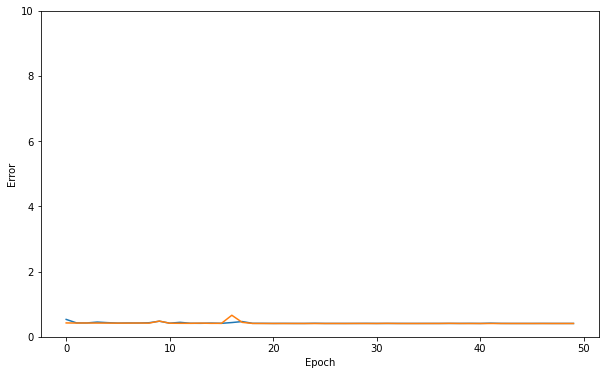

In [262]:
def plot_loss(history3_2A):
  plt.plot(history3_2A.history['loss'], label='loss')
  plt.plot(history3_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_2A)

**MODEL3_2B**

rmsprop

In [263]:
model3_2B = Sequential()
model3_2B.add(Dense(3, activation='relu', input_dim=(3)))
model3_2B.add(Dense(32, activation='relu'))
model3_2B.add(Dense(64, activation='relu'))
model3_2B.add(Dense(64, activation='relu'))
model3_2B.add(Dense(32, activation='relu'))
model3_2B.add(Dense(1, name='output'))
model3_2B.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 3)                 12        
                                                                 
 dense_54 (Dense)            (None, 32)                128       
                                                                 
 dense_55 (Dense)            (None, 64)                2112      
                                                                 
 dense_56 (Dense)            (None, 64)                4160      
                                                                 
 dense_57 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [264]:
model3_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [265]:
start_time3_2B = time.time()
history3_2B = model3_2B.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_2B = time.time()

Epoch 1/50
496/496 [==============================] - 4s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4710 - mean_absolute_error: 0.3570 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4677 - val_mean_absolute_error: 0.3538
Epoch 2/50
496/496 [==============================] - 3s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4710 - mean_absolute_error: 0.3570 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4677 - val_mean_absolute_error: 0.3538
Epoch 3/50
496/496 [==============================] - 3s 6ms/step - loss: 5.3154 - root_mean_squared_error: 0.4710 - mean_absolute_error: 0.3570 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4677 - val_mean_absolute_error: 0.3538
Epoch 4/50
496/496 [==============================] - 3s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4710 - mean_absolute_error: 0.3570 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4677 - val_mean_absolute_error: 0.3538
Epoch 5/50
496/496 [==============================] - 3s

In [266]:
print("--- %s seconds ---" % (end_time3_2B - start_time3_2B))

--- 159.59994053840637 seconds ---


In [267]:
y_pred3_2B = model3_2B.predict(x_test3)
metric3_2B = r2_score(y_test3, y_pred3_2B)
metric3_2B

-1.268512117823816

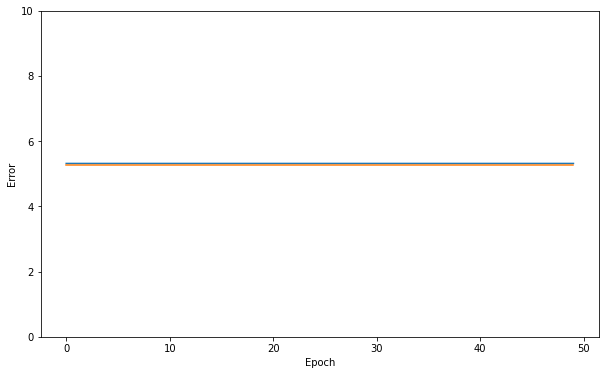

In [268]:
def plot_loss(history3_2B):
  plt.plot(history3_2B.history['loss'], label='loss')
  plt.plot(history3_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_2B)

**MODEL3_2C**

sgd

In [269]:
model3_2C = Sequential()
model3_2C.add(Dense(3, activation='relu', input_dim=(3)))
model3_2C.add(Dense(32, activation='relu'))
model3_2C.add(Dense(64, activation='relu'))
model3_2C.add(Dense(64, activation='relu'))
model3_2C.add(Dense(32, activation='relu'))
model3_2C.add(Dense(1, name='output'))
model3_2C.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 3)                 12        
                                                                 
 dense_59 (Dense)            (None, 32)                128       
                                                                 
 dense_60 (Dense)            (None, 64)                2112      
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [270]:
model3_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [271]:
start_time3_2C = time.time()
history3_2C = model3_2C.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_2C = time.time()

Epoch 1/50
496/496 [==============================] - 4s 6ms/step - loss: 9.9820 - root_mean_squared_error: 1.2550 - mean_absolute_error: 1.2218 - val_loss: 10.0434 - val_root_mean_squared_error: 1.2586 - val_mean_absolute_error: 1.2262
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 9.9944 - root_mean_squared_error: 1.2559 - mean_absolute_error: 1.2232 - val_loss: 10.0434 - val_root_mean_squared_error: 1.2586 - val_mean_absolute_error: 1.2262
Epoch 3/50
496/496 [==============================] - 3s 5ms/step - loss: 9.9944 - root_mean_squared_error: 1.2559 - mean_absolute_error: 1.2232 - val_loss: 10.0434 - val_root_mean_squared_error: 1.2586 - val_mean_absolute_error: 1.2262
Epoch 4/50
496/496 [==============================] - 3s 6ms/step - loss: 9.9944 - root_mean_squared_error: 1.2559 - mean_absolute_error: 1.2232 - val_loss: 10.0434 - val_root_mean_squared_error: 1.2586 - val_mean_absolute_error: 1.2262
Epoch 5/50
496/496 [==============================] 

In [272]:
print("--- %s seconds ---" % (end_time3_2C - start_time3_2C))

--- 134.25835037231445 seconds ---


In [273]:
y_pred3_2C = model3_2C.predict(x_test3)
metric3_2C = r2_score(y_test3, y_pred3_2C)
metric3_2C

-15.073589158367753

**MODEL4_2A**

adam

In [274]:
model4_2A = Sequential()
model4_2A.add(Dense(3, activation='relu', input_dim=(3)))
model4_2A.add(Dense(32, activation='relu'))
model4_2A.add(Dense(64, activation='relu'))
model4_2A.add(Dense(64, activation='relu'))
model4_2A.add(Dense(32, activation='relu'))
model4_2A.add(Dense(1, name='output'))
model4_2A.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 3)                 12        
                                                                 
 dense_64 (Dense)            (None, 32)                128       
                                                                 
 dense_65 (Dense)            (None, 64)                2112      
                                                                 
 dense_66 (Dense)            (None, 64)                4160      
                                                                 
 dense_67 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [275]:
model4_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [276]:
start_time4_2A = time.time()
history4_2A = model4_2A.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_2A = time.time()

Epoch 1/50
447/447 [==============================] - 3s 6ms/step - loss: 0.4913 - root_mean_squared_error: 0.1899 - mean_absolute_error: 0.1297 - val_loss: 0.4339 - val_root_mean_squared_error: 0.1202 - val_mean_absolute_error: 0.0662
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4269 - root_mean_squared_error: 0.1051 - mean_absolute_error: 0.0580 - val_loss: 0.4280 - val_root_mean_squared_error: 0.0943 - val_mean_absolute_error: 0.0468
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4438 - root_mean_squared_error: 0.1301 - mean_absolute_error: 0.0723 - val_loss: 0.4508 - val_root_mean_squared_error: 0.1323 - val_mean_absolute_error: 0.1135
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4477 - root_mean_squared_error: 0.1371 - mean_absolute_error: 0.0737 - val_loss: 0.4165 - val_root_mean_squared_error: 0.0832 - val_mean_absolute_error: 0.0464
Epoch 5/50
447/447 [==============================] - 2s

In [277]:
print("--- %s seconds ---" % (end_time4_2A - start_time4_2A))

--- 142.63727521896362 seconds ---


In [278]:
y_pred4_2A = model4_2A.predict(x_test4)
metric4_2A = r2_score(y_test4, y_pred4_2A)
metric4_2A

0.9960325261176778

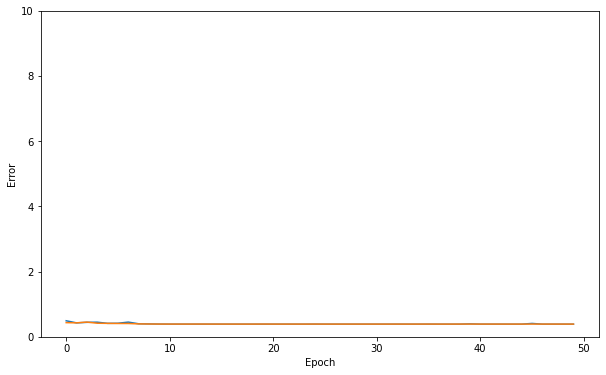

In [279]:
def plot_loss(history4_2A):
  plt.plot(history4_2A.history['loss'], label='loss')
  plt.plot(history4_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_2A)

**MODEL4_2B**

rmsprop

In [280]:
model4_2B = Sequential()
model4_2B.add(Dense(3, activation='relu', input_dim=(3)))
model4_2B.add(Dense(32, activation='relu'))
model4_2B.add(Dense(64, activation='relu'))
model4_2B.add(Dense(64, activation='relu'))
model4_2B.add(Dense(32, activation='relu'))
model4_2B.add(Dense(1, name='output'))
model4_2B.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 3)                 12        
                                                                 
 dense_69 (Dense)            (None, 32)                128       
                                                                 
 dense_70 (Dense)            (None, 64)                2112      
                                                                 
 dense_71 (Dense)            (None, 64)                4160      
                                                                 
 dense_72 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [281]:
model4_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [282]:
start_time4_2B = time.time()
history4_2B = model4_2B.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_2B = time.time()

Epoch 1/50
447/447 [==============================] - 4s 6ms/step - loss: 6.5007 - root_mean_squared_error: 0.5539 - mean_absolute_error: 0.4259 - val_loss: 6.5096 - val_root_mean_squared_error: 0.5533 - val_mean_absolute_error: 0.4265
Epoch 2/50
447/447 [==============================] - 3s 6ms/step - loss: 6.5007 - root_mean_squared_error: 0.5539 - mean_absolute_error: 0.4259 - val_loss: 6.5096 - val_root_mean_squared_error: 0.5533 - val_mean_absolute_error: 0.4265
Epoch 3/50
447/447 [==============================] - 3s 6ms/step - loss: 6.5007 - root_mean_squared_error: 0.5539 - mean_absolute_error: 0.4259 - val_loss: 6.5096 - val_root_mean_squared_error: 0.5533 - val_mean_absolute_error: 0.4265
Epoch 4/50
447/447 [==============================] - 3s 6ms/step - loss: 6.5007 - root_mean_squared_error: 0.5539 - mean_absolute_error: 0.4259 - val_loss: 6.5096 - val_root_mean_squared_error: 0.5533 - val_mean_absolute_error: 0.4265
Epoch 5/50
447/447 [==============================] - 3s

In [283]:
print("--- %s seconds ---" % (end_time4_2B - start_time4_2B))

--- 142.9532172679901 seconds ---


In [284]:
y_pred4_2B = model4_2B.predict(x_test4)
metric4_2B = r2_score(y_test4, y_pred4_2B)
metric4_2B

-1.498633688460894

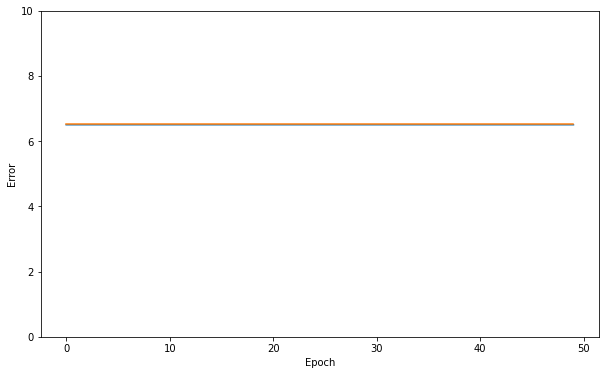

In [285]:
def plot_loss(history4_2B):
  plt.plot(history4_2B.history['loss'], label='loss')
  plt.plot(history4_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_2B)

**MODEL4_2C**

sgd

In [286]:
model4_2C = Sequential()
model4_2C.add(Dense(3, activation='relu', input_dim=(3)))
model4_2C.add(Dense(32, activation='relu'))
model4_2C.add(Dense(64, activation='relu'))
model4_2C.add(Dense(64, activation='relu'))
model4_2C.add(Dense(32, activation='relu'))
model4_2C.add(Dense(1, name='output'))
model4_2C.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_73 (Dense)            (None, 3)                 12        
                                                                 
 dense_74 (Dense)            (None, 32)                128       
                                                                 
 dense_75 (Dense)            (None, 64)                2112      
                                                                 
 dense_76 (Dense)            (None, 64)                4160      
                                                                 
 dense_77 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [287]:
model4_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [288]:
start_time4_2C = time.time()
history4_2C = model4_2C.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_2C = time.time()

Epoch 1/50
447/447 [==============================] - 3s 5ms/step - loss: 6.5007 - root_mean_squared_error: 0.6332 - mean_absolute_error: 0.5133 - val_loss: 6.5096 - val_root_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.5135
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 6.5007 - root_mean_squared_error: 0.6332 - mean_absolute_error: 0.5133 - val_loss: 6.5096 - val_root_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.5135
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 6.5007 - root_mean_squared_error: 0.6332 - mean_absolute_error: 0.5133 - val_loss: 6.5096 - val_root_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.5135
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 6.5007 - root_mean_squared_error: 0.6332 - mean_absolute_error: 0.5133 - val_loss: 6.5096 - val_root_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.5135
Epoch 5/50
447/447 [==============================] - 2s

In [289]:
print("--- %s seconds ---" % (end_time4_2C - start_time4_2C))

--- 115.14213132858276 seconds ---


In [290]:
y_pred4_2C = model4_2C.predict(x_test4)
metric4_2C = r2_score(y_test4, y_pred4_2C)
metric4_2C

-2.2674072273685955

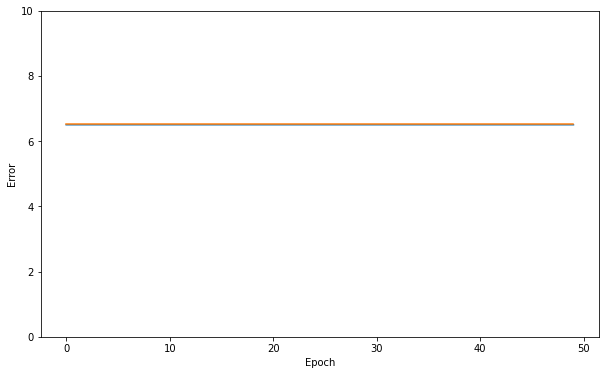

In [291]:
def plot_loss(history4_2C):
  plt.plot(history4_2C.history['loss'], label='loss')
  plt.plot(history4_2C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_2C)

**MODEL5_2A**

adam

In [292]:
model5_2A = Sequential()
model5_2A.add(Dense(3, activation='relu', input_dim=(3)))
model5_2A.add(Dense(32, activation='relu'))
model5_2A.add(Dense(64, activation='relu'))
model5_2A.add(Dense(64, activation='relu'))
model5_2A.add(Dense(32, activation='relu'))
model5_2A.add(Dense(1, name='output'))
model5_2A.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 3)                 12        
                                                                 
 dense_79 (Dense)            (None, 32)                128       
                                                                 
 dense_80 (Dense)            (None, 64)                2112      
                                                                 
 dense_81 (Dense)            (None, 64)                4160      
                                                                 
 dense_82 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [293]:
model5_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [294]:
start_time5_2A = time.time()
history5_2A = model5_2A.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_2A = time.time()

Epoch 1/50
424/424 [==============================] - 3s 6ms/step - loss: 0.4456 - root_mean_squared_error: 0.1205 - mean_absolute_error: 0.0604 - val_loss: 0.4148 - val_root_mean_squared_error: 0.0645 - val_mean_absolute_error: 0.0358
Epoch 2/50
424/424 [==============================] - 3s 6ms/step - loss: 0.4549 - root_mean_squared_error: 0.1536 - mean_absolute_error: 0.0816 - val_loss: 0.4052 - val_root_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.0294
Epoch 3/50
424/424 [==============================] - 3s 6ms/step - loss: 0.4019 - root_mean_squared_error: 0.0448 - mean_absolute_error: 0.0304 - val_loss: 0.3987 - val_root_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.0228
Epoch 4/50
424/424 [==============================] - 2s 6ms/step - loss: 0.4185 - root_mean_squared_error: 0.0941 - mean_absolute_error: 0.0476 - val_loss: 0.4613 - val_root_mean_squared_error: 0.1420 - val_mean_absolute_error: 0.1174
Epoch 5/50
424/424 [==============================] - 3s

In [295]:
print("--- %s seconds ---" % (end_time5_2A - start_time5_2A))

--- 121.81365060806274 seconds ---


In [296]:
y_pred5_2A = model5_2A.predict(x_test5)
metric5_2A = r2_score(y_test5, y_pred5_2A)
metric5_2A

0.9953010104178281

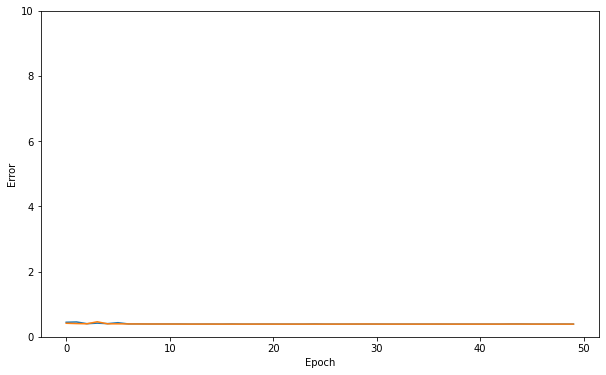

In [297]:
def plot_loss(history5_2A):
  plt.plot(history5_2A.history['loss'], label='loss')
  plt.plot(history5_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_2A)

**MODEL5_2B**

rmsprop

In [298]:
model5_2B = Sequential()
model5_2B.add(Dense(3, activation='relu', input_dim=(3)))
model5_2B.add(Dense(32, activation='relu'))
model5_2B.add(Dense(64, activation='relu'))
model5_2B.add(Dense(64, activation='relu'))
model5_2B.add(Dense(32, activation='relu'))
model5_2B.add(Dense(1, name='output'))
model5_2B.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 3)                 12        
                                                                 
 dense_84 (Dense)            (None, 32)                128       
                                                                 
 dense_85 (Dense)            (None, 64)                2112      
                                                                 
 dense_86 (Dense)            (None, 64)                4160      
                                                                 
 dense_87 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [299]:
model5_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [300]:
start_time5_2B = time.time()
history5_2B = model5_2B.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_2B = time.time()

Epoch 1/50
424/424 [==============================] - 4s 7ms/step - loss: 5.5081 - root_mean_squared_error: 0.4846 - mean_absolute_error: 0.3580 - val_loss: 5.6524 - val_root_mean_squared_error: 0.4944 - val_mean_absolute_error: 0.3674
Epoch 2/50
424/424 [==============================] - 3s 7ms/step - loss: 5.5081 - root_mean_squared_error: 0.4846 - mean_absolute_error: 0.3580 - val_loss: 5.6524 - val_root_mean_squared_error: 0.4944 - val_mean_absolute_error: 0.3674
Epoch 3/50
424/424 [==============================] - 3s 6ms/step - loss: 5.5081 - root_mean_squared_error: 0.4846 - mean_absolute_error: 0.3580 - val_loss: 5.6524 - val_root_mean_squared_error: 0.4944 - val_mean_absolute_error: 0.3674
Epoch 4/50
424/424 [==============================] - 3s 6ms/step - loss: 5.5081 - root_mean_squared_error: 0.4846 - mean_absolute_error: 0.3580 - val_loss: 5.6524 - val_root_mean_squared_error: 0.4944 - val_mean_absolute_error: 0.3674
Epoch 5/50
424/424 [==============================] - 3s

In [301]:
print("--- %s seconds ---" % (end_time5_2B - start_time5_2B))

--- 140.56074476242065 seconds ---


In [302]:
y_pred5_2B = model5_2B.predict(x_test5)
metric5_2B = r2_score(y_test5, y_pred5_2B)
metric5_2B

-1.1796469273281533

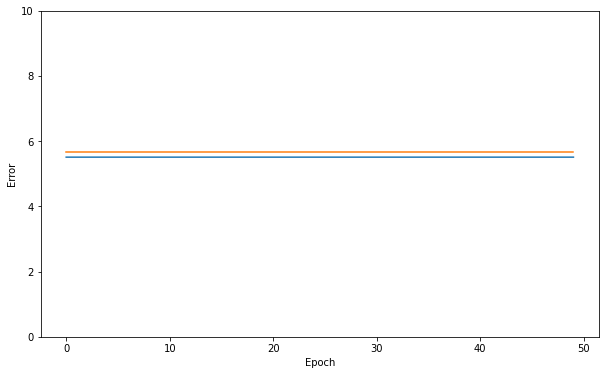

In [303]:
def plot_loss(history5_2B):
  plt.plot(history5_2B.history['loss'], label='loss')
  plt.plot(history5_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_2B)

**MODEL5_2C**

sgd

In [304]:
model5_2C = Sequential()
model5_2C.add(Dense(3, activation='relu', input_dim=(3)))
model5_2C.add(Dense(32, activation='relu'))
model5_2C.add(Dense(64, activation='relu'))
model5_2C.add(Dense(64, activation='relu'))
model5_2C.add(Dense(32, activation='relu'))
model5_2C.add(Dense(1, name='output'))
model5_2C.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 3)                 12        
                                                                 
 dense_89 (Dense)            (None, 32)                128       
                                                                 
 dense_90 (Dense)            (None, 64)                2112      
                                                                 
 dense_91 (Dense)            (None, 64)                4160      
                                                                 
 dense_92 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [305]:
model5_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [306]:
start_time5_2C = time.time()
history5_2C = model5_2C.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_2C = time.time()

Epoch 1/50
424/424 [==============================] - 3s 6ms/step - loss: 9.7835 - root_mean_squared_error: 1.4894 - mean_absolute_error: 1.4548 - val_loss: 9.6612 - val_root_mean_squared_error: 1.4836 - val_mean_absolute_error: 1.4489
Epoch 2/50
424/424 [==============================] - 2s 6ms/step - loss: 9.8039 - root_mean_squared_error: 1.4911 - mean_absolute_error: 1.4575 - val_loss: 9.6612 - val_root_mean_squared_error: 1.4836 - val_mean_absolute_error: 1.4489
Epoch 3/50
424/424 [==============================] - 2s 6ms/step - loss: 9.8039 - root_mean_squared_error: 1.4911 - mean_absolute_error: 1.4575 - val_loss: 9.6612 - val_root_mean_squared_error: 1.4836 - val_mean_absolute_error: 1.4489
Epoch 4/50
424/424 [==============================] - 2s 5ms/step - loss: 9.8039 - root_mean_squared_error: 1.4911 - mean_absolute_error: 1.4575 - val_loss: 9.6612 - val_root_mean_squared_error: 1.4836 - val_mean_absolute_error: 1.4489
Epoch 5/50
424/424 [==============================] - 2s

In [307]:
print("--- %s seconds ---" % (end_time5_2C - start_time5_2C))

--- 116.48296570777893 seconds ---


In [308]:
y_pred5_2C = model5_2C.predict(x_test5)
metric5_2C = r2_score(y_test5, y_pred5_2C)
metric5_2C

-19.01716575616183

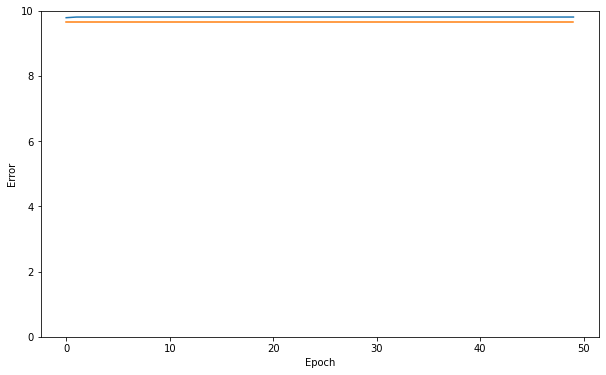

In [309]:
def plot_loss(history5_2C):
  plt.plot(history5_2C.history['loss'], label='loss')
  plt.plot(history5_2C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_2C)

**MODEL6_2A**

adam

In [310]:
model6_2A = Sequential()
model6_2A.add(Dense(3, activation='relu', input_dim=(3)))
model6_2A.add(Dense(32, activation='relu'))
model6_2A.add(Dense(64, activation='relu'))
model6_2A.add(Dense(64, activation='relu'))
model6_2A.add(Dense(32, activation='relu'))
model6_2A.add(Dense(1, name='output'))
model6_2A.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 3)                 12        
                                                                 
 dense_94 (Dense)            (None, 32)                128       
                                                                 
 dense_95 (Dense)            (None, 64)                2112      
                                                                 
 dense_96 (Dense)            (None, 64)                4160      
                                                                 
 dense_97 (Dense)            (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [311]:
model6_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [312]:
start_time6_2A = time.time()
history6_2A = model6_2A.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_2A = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 0.4804 - root_mean_squared_error: 0.1868 - mean_absolute_error: 0.1243 - val_loss: 0.4090 - val_root_mean_squared_error: 0.1112 - val_mean_absolute_error: 0.0543
Epoch 2/50
454/454 [==============================] - 2s 5ms/step - loss: 0.4093 - root_mean_squared_error: 0.1032 - mean_absolute_error: 0.0532 - val_loss: 0.4074 - val_root_mean_squared_error: 0.1096 - val_mean_absolute_error: 0.0514
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.4117 - root_mean_squared_error: 0.0965 - mean_absolute_error: 0.0574 - val_loss: 0.4017 - val_root_mean_squared_error: 0.0805 - val_mean_absolute_error: 0.0429
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.4040 - root_mean_squared_error: 0.0780 - mean_absolute_error: 0.0447 - val_loss: 0.4003 - val_root_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.0392
Epoch 5/50
454/454 [==============================] - 2s

In [313]:
print("--- %s seconds ---" % (end_time6_2A - start_time6_2A))

--- 125.82624697685242 seconds ---


In [314]:
y_pred6_2A = model6_2A.predict(x_test6)
metric6_2A = r2_score(y_test6, y_pred6_2A)
metric6_2A

0.9940680934014948

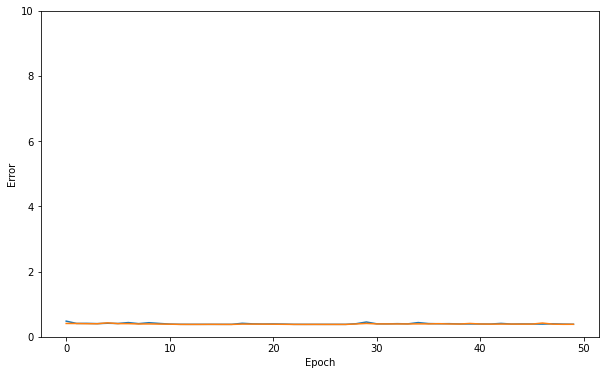

In [315]:
def plot_loss(history6_2A):
  plt.plot(history6_2A.history['loss'], label='loss')
  plt.plot(history6_2A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_2A)

**MODEL6_2B**

rmsprop

In [316]:
model6_2B = Sequential()
model6_2B.add(Dense(3, activation='relu', input_dim=(3)))
model6_2B.add(Dense(32, activation='relu'))
model6_2B.add(Dense(64, activation='relu'))
model6_2B.add(Dense(64, activation='relu'))
model6_2B.add(Dense(32, activation='relu'))
model6_2B.add(Dense(1, name='output'))
model6_2B.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_98 (Dense)            (None, 3)                 12        
                                                                 
 dense_99 (Dense)            (None, 32)                128       
                                                                 
 dense_100 (Dense)           (None, 64)                2112      
                                                                 
 dense_101 (Dense)           (None, 64)                4160      
                                                                 
 dense_102 (Dense)           (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [317]:
model6_2B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [318]:
start_time6_2B = time.time()
history6_2B = model6_2B.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_2B = time.time()

Epoch 1/50
454/454 [==============================] - 4s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5825 - mean_absolute_error: 0.4595 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5845 - val_mean_absolute_error: 0.4613
Epoch 2/50
454/454 [==============================] - 3s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5825 - mean_absolute_error: 0.4595 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5845 - val_mean_absolute_error: 0.4613
Epoch 3/50
454/454 [==============================] - 3s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5825 - mean_absolute_error: 0.4595 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5845 - val_mean_absolute_error: 0.4613
Epoch 4/50
454/454 [==============================] - 3s 6ms/step - loss: 6.4066 - root_mean_squared_error: 0.5825 - mean_absolute_error: 0.4595 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5845 - val_mean_absolute_error: 0.4613
Epoch 5/50
454/454 [==============================] - 3s

In [319]:
print("--- %s seconds ---" % (end_time6_2B - start_time6_2B))

--- 202.96246528625488 seconds ---


In [320]:
y_pred6_2B = model6_2B.predict(x_test6)
metric6_2B = r2_score(y_test6, y_pred6_2B)
metric6_2B

-1.7645562665722703

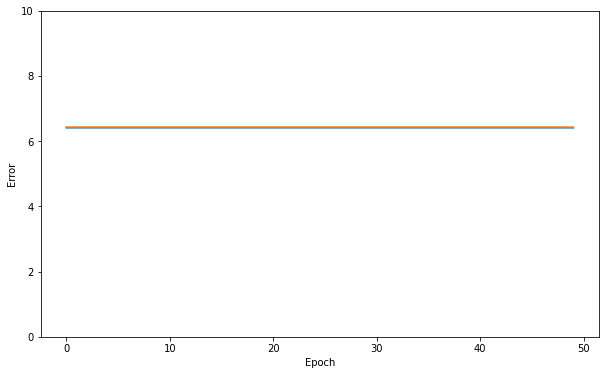

In [321]:
def plot_loss(history6_2B):
  plt.plot(history6_2B.history['loss'], label='loss')
  plt.plot(history6_2B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_2B)

**MODEL6_2C**

sgd

In [322]:
model6_2C = Sequential()
model6_2C.add(Dense(3, activation='relu', input_dim=(3)))
model6_2C.add(Dense(32, activation='relu'))
model6_2C.add(Dense(64, activation='relu'))
model6_2C.add(Dense(64, activation='relu'))
model6_2C.add(Dense(32, activation='relu'))
model6_2C.add(Dense(1, name='output'))
model6_2C.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 3)                 12        
                                                                 
 dense_104 (Dense)           (None, 32)                128       
                                                                 
 dense_105 (Dense)           (None, 64)                2112      
                                                                 
 dense_106 (Dense)           (None, 64)                4160      
                                                                 
 dense_107 (Dense)           (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-train

In [323]:
model6_2C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [324]:
start_time6_2C = time.time()
history6_2C = model6_2C.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_2C = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 6.4066 - root_mean_squared_error: 0.6102 - mean_absolute_error: 0.4936 - val_loss: 6.4333 - val_root_mean_squared_error: 0.6119 - val_mean_absolute_error: 0.4952
Epoch 2/50
454/454 [==============================] - 3s 6ms/step - loss: 6.4066 - root_mean_squared_error: 0.6102 - mean_absolute_error: 0.4936 - val_loss: 6.4333 - val_root_mean_squared_error: 0.6119 - val_mean_absolute_error: 0.4952
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 6.4066 - root_mean_squared_error: 0.6102 - mean_absolute_error: 0.4936 - val_loss: 6.4333 - val_root_mean_squared_error: 0.6119 - val_mean_absolute_error: 0.4952
Epoch 4/50
454/454 [==============================] - 3s 6ms/step - loss: 6.4066 - root_mean_squared_error: 0.6102 - mean_absolute_error: 0.4936 - val_loss: 6.4333 - val_root_mean_squared_error: 0.6119 - val_mean_absolute_error: 0.4952
Epoch 5/50
454/454 [==============================] - 2s

In [325]:
print("--- %s seconds ---" % (end_time6_2C - start_time6_2C))

--- 121.50676131248474 seconds ---


In [326]:
y_pred6_2C = model6_2C.predict(x_test6)
metric6_2C = r2_score(y_test6, y_pred6_2C)
metric6_2C

-2.0359908395387727

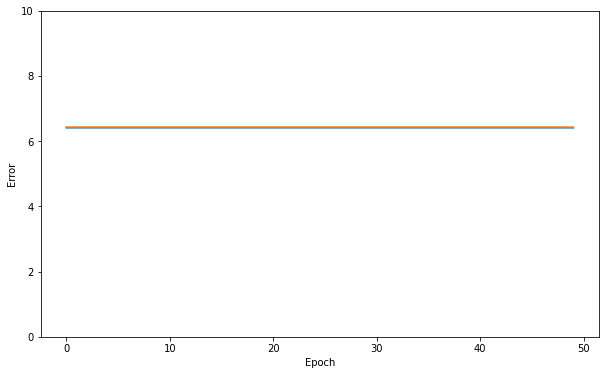

In [327]:
def plot_loss(history6_2C):
  plt.plot(history6_2C.history['loss'], label='loss')
  plt.plot(history6_2C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_2C)

#MODEL 3

4 node input layer, two 64 node hidden layer, one 1 node hidden layer, two 64 node hidden layer, one output layer

**MODEL1_3A**

ADAM

In [328]:
model1_3A = Sequential()
model1_3A.add(Dense(3, activation='relu', input_dim=(3)))
model1_3A.add(Dense(64, activation='relu' ))
model1_3A.add(Dense(64, activation='relu' ))
model1_3A.add(Dense(64, activation='relu'))
model1_3A.add(Dense(64, activation='relu'))
model1_3A.add(Dense(64, activation='relu'))
model1_3A.add(Dense(32, activation='relu'))
model1_3A.add(Dense(1, name='output'))
model1_3A.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 3)                 12        
                                                                 
 dense_109 (Dense)           (None, 64)                256       
                                                                 
 dense_110 (Dense)           (None, 64)                4160      
                                                                 
 dense_111 (Dense)           (None, 64)                4160      
                                                                 
 dense_112 (Dense)           (None, 64)                4160      
                                                                 
 dense_113 (Dense)           (None, 64)                4160      
                                                                 
 dense_114 (Dense)           (None, 32)              

In [329]:
model1_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [330]:
start_time1_3A = time.time()
history1_3A = model1_3A.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_3A = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 1.0016 - root_mean_squared_error: 0.4123 - mean_absolute_error: 0.3275 - val_loss: 0.6841 - val_root_mean_squared_error: 0.3325 - val_mean_absolute_error: 0.2928
Epoch 2/50
522/522 [==============================] - 3s 6ms/step - loss: 0.6830 - root_mean_squared_error: 0.3345 - mean_absolute_error: 0.2940 - val_loss: 0.6838 - val_root_mean_squared_error: 0.3323 - val_mean_absolute_error: 0.2917
Epoch 3/50
522/522 [==============================] - 3s 6ms/step - loss: 0.6826 - root_mean_squared_error: 0.3342 - mean_absolute_error: 0.2938 - val_loss: 0.6834 - val_root_mean_squared_error: 0.3321 - val_mean_absolute_error: 0.2909
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 0.6823 - root_mean_squared_error: 0.3341 - mean_absolute_error: 0.2935 - val_loss: 0.6829 - val_root_mean_squared_error: 0.3317 - val_mean_absolute_error: 0.2918
Epoch 5/50
522/522 [==============================] - 3s

In [331]:
print("--- %s seconds ---" % (end_time1_3A - start_time1_3A))

--- 202.7330083847046 seconds ---


In [332]:
y_pred1_3A = model1_3A.predict(x_test1)
metric1_3A = r2_score(y_test1, y_pred1_3A)
metric1_3A

0.7495280117606317

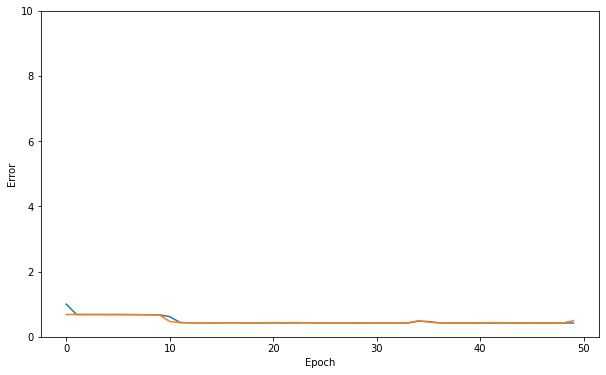

In [333]:
def plot_loss(history1_3A):
  plt.plot(history1_3A.history['loss'], label='loss')
  plt.plot(history1_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_3A)

**MODEL1_3B**

RMSPROP

In [334]:
model1_3B = Sequential()
model1_3B.add(Dense(3, activation='relu', input_dim=(3)))
model1_3B.add(Dense(64, activation='relu' ))
model1_3B.add(Dense(64, activation='relu' ))
model1_3B.add(Dense(64, activation='relu'))
model1_3B.add(Dense(64, activation='relu'))
model1_3B.add(Dense(64, activation='relu'))
model1_3B.add(Dense(32, activation='relu'))
model1_3B.add(Dense(1, name='output'))
model1_3B.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 3)                 12        
                                                                 
 dense_116 (Dense)           (None, 64)                256       
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dense_119 (Dense)           (None, 64)                4160      
                                                                 
 dense_120 (Dense)           (None, 64)                4160      
                                                                 
 dense_121 (Dense)           (None, 32)              

In [335]:
model1_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [336]:
start_time1_3B = time.time()
history1_3B = model1_3B.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_3B = time.time()

Epoch 1/50
522/522 [==============================] - 5s 8ms/step - loss: 6.6056 - root_mean_squared_error: 0.5488 - mean_absolute_error: 0.4345 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5506 - val_mean_absolute_error: 0.4383
Epoch 2/50
522/522 [==============================] - 4s 7ms/step - loss: 6.6056 - root_mean_squared_error: 0.5488 - mean_absolute_error: 0.4345 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5506 - val_mean_absolute_error: 0.4383
Epoch 3/50
522/522 [==============================] - 4s 7ms/step - loss: 6.6056 - root_mean_squared_error: 0.5488 - mean_absolute_error: 0.4345 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5506 - val_mean_absolute_error: 0.4383
Epoch 4/50
522/522 [==============================] - 4s 7ms/step - loss: 6.6056 - root_mean_squared_error: 0.5488 - mean_absolute_error: 0.4345 - val_loss: 6.6638 - val_root_mean_squared_error: 0.5506 - val_mean_absolute_error: 0.4383
Epoch 5/50
522/522 [==============================] - 4s

In [337]:
print("--- %s seconds ---" % (end_time1_3B - start_time1_3B))

--- 181.26069140434265 seconds ---


In [338]:
y_pred1_3B = model1_3B.predict(x_test1)
metric1_3B = r2_score(y_test1, y_pred1_3B)
metric1_3B

-1.6645930700178688

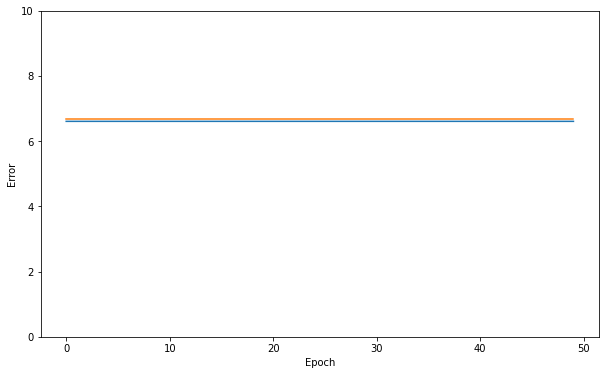

In [339]:
def plot_loss(history1_3B):
  plt.plot(history1_3B.history['loss'], label='loss')
  plt.plot(history1_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_3B)

**MODEL1_3C**

SGD

In [340]:
model1_3C = Sequential()
model1_3C.add(Dense(3, activation='relu', input_dim=(3)))
model1_3C.add(Dense(64, activation='relu' ))
model1_3C.add(Dense(64, activation='relu' ))
model1_3C.add(Dense(64, activation='relu'))
model1_3C.add(Dense(64, activation='relu'))
model1_3C.add(Dense(64, activation='relu'))
model1_3C.add(Dense(32, activation='relu'))
model1_3C.add(Dense(1, name='output'))
model1_3C.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_122 (Dense)           (None, 3)                 12        
                                                                 
 dense_123 (Dense)           (None, 64)                256       
                                                                 
 dense_124 (Dense)           (None, 64)                4160      
                                                                 
 dense_125 (Dense)           (None, 64)                4160      
                                                                 
 dense_126 (Dense)           (None, 64)                4160      
                                                                 
 dense_127 (Dense)           (None, 64)                4160      
                                                                 
 dense_128 (Dense)           (None, 32)              

In [341]:
model1_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [342]:
start_time1_3C = time.time()
history1_3C = model1_3C.fit(x_train1, y_train1, validation_data=(x_val1, y_val1), epochs=50, batch_size=50, verbose=1)
end_time1_3C = time.time()

Epoch 1/50
522/522 [==============================] - 4s 6ms/step - loss: 8.7088 - root_mean_squared_error: 7.4295 - mean_absolute_error: 7.4160 - val_loss: 8.6613 - val_root_mean_squared_error: 7.4328 - val_mean_absolute_error: 7.4257
Epoch 2/50
522/522 [==============================] - 3s 6ms/step - loss: 8.7188 - root_mean_squared_error: 7.4365 - mean_absolute_error: 7.4293 - val_loss: 8.6613 - val_root_mean_squared_error: 7.4328 - val_mean_absolute_error: 7.4257
Epoch 3/50
522/522 [==============================] - 3s 5ms/step - loss: 8.7188 - root_mean_squared_error: 7.4365 - mean_absolute_error: 7.4293 - val_loss: 8.6613 - val_root_mean_squared_error: 7.4328 - val_mean_absolute_error: 7.4257
Epoch 4/50
522/522 [==============================] - 3s 5ms/step - loss: 8.7188 - root_mean_squared_error: 7.4365 - mean_absolute_error: 7.4293 - val_loss: 8.6613 - val_root_mean_squared_error: 7.4328 - val_mean_absolute_error: 7.4257
Epoch 5/50
522/522 [==============================] - 3s

In [343]:
print("--- %s seconds ---" % (end_time1_3C - start_time1_3C))

--- 202.62942957878113 seconds ---


In [344]:
y_pred1_3C = model1_3C.predict(x_test1)
metric1_3C = r2_score(y_test1, y_pred1_3C)
metric1_3C

-486.80136765818236

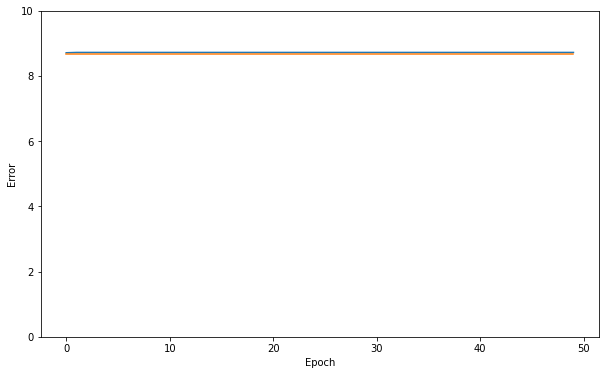

In [345]:
def plot_loss(history1_3C):
  plt.plot(history1_3C.history['loss'], label='loss')
  plt.plot(history1_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history1_3C)

**MODEL2_3A**

ADAM

In [346]:
model2_3A = Sequential()
model2_3A.add(Dense(3, activation='relu', input_dim=(3)))
model2_3A.add(Dense(64, activation='relu' ))
model2_3A.add(Dense(64, activation='relu' ))
model2_3A.add(Dense(64, activation='relu'))
model2_3A.add(Dense(64, activation='relu'))
model2_3A.add(Dense(64, activation='relu'))
model2_3A.add(Dense(32, activation='relu'))
model2_3A.add(Dense(1, name='output'))
model2_3A.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 3)                 12        
                                                                 
 dense_130 (Dense)           (None, 64)                256       
                                                                 
 dense_131 (Dense)           (None, 64)                4160      
                                                                 
 dense_132 (Dense)           (None, 64)                4160      
                                                                 
 dense_133 (Dense)           (None, 64)                4160      
                                                                 
 dense_134 (Dense)           (None, 64)                4160      
                                                                 
 dense_135 (Dense)           (None, 32)              

In [347]:
model2_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [348]:
start_time2_3A = time.time()
history2_3A = model2_3A.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_3A = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.5191 - mean_absolute_error: 0.4073 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5216 - val_mean_absolute_error: 0.4098
Epoch 2/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.5191 - mean_absolute_error: 0.4073 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5216 - val_mean_absolute_error: 0.4098
Epoch 3/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.5191 - mean_absolute_error: 0.4073 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5216 - val_mean_absolute_error: 0.4098
Epoch 4/50
495/495 [==============================] - 3s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.5191 - mean_absolute_error: 0.4073 - val_loss: 5.8263 - val_root_mean_squared_error: 0.5216 - val_mean_absolute_error: 0.4098
Epoch 5/50
495/495 [==============================] - 3s

In [349]:
print("--- %s seconds ---" % (end_time2_3A - start_time2_3A))

--- 202.737948179245 seconds ---


In [350]:
y_pred2_3A = model2_3A.predict(x_test2)
metric2_3A = r2_score(y_test2, y_pred2_3A)
metric2_3A

-1.603685185794669

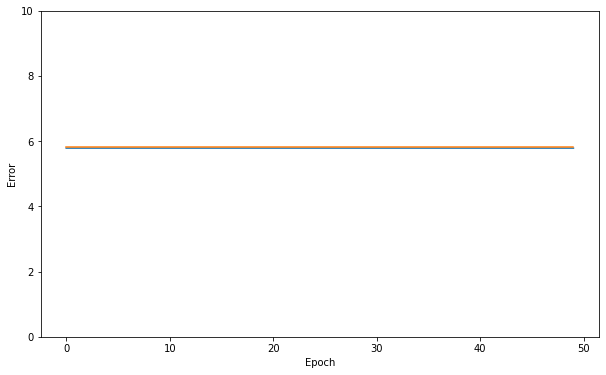

In [351]:
def plot_loss(history2_3A):
  plt.plot(history2_3A.history['loss'], label='loss')
  plt.plot(history2_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_3A)

**MODEL2_3B**

RMSPROP

In [352]:
model2_3B = Sequential()
model2_3B.add(Dense(3, activation='relu', input_dim=(3)))
model2_3B.add(Dense(64, activation='relu' ))
model2_3B.add(Dense(64, activation='relu' ))
model2_3B.add(Dense(64, activation='relu'))
model2_3B.add(Dense(64, activation='relu'))
model2_3B.add(Dense(64, activation='relu'))
model2_3B.add(Dense(32, activation='relu'))
model2_3B.add(Dense(1, name='output'))
model2_3B.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 3)                 12        
                                                                 
 dense_137 (Dense)           (None, 64)                256       
                                                                 
 dense_138 (Dense)           (None, 64)                4160      
                                                                 
 dense_139 (Dense)           (None, 64)                4160      
                                                                 
 dense_140 (Dense)           (None, 64)                4160      
                                                                 
 dense_141 (Dense)           (None, 64)                4160      
                                                                 
 dense_142 (Dense)           (None, 32)              

In [353]:
model2_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [354]:
start_time2_3B = time.time()
history2_3B = model2_3B.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_3B = time.time()

Epoch 1/50
495/495 [==============================] - 6s 9ms/step - loss: 0.4608 - root_mean_squared_error: 0.1318 - mean_absolute_error: 0.0807 - val_loss: 0.4323 - val_root_mean_squared_error: 0.0847 - val_mean_absolute_error: 0.0537
Epoch 2/50
495/495 [==============================] - 3s 7ms/step - loss: 0.4375 - root_mean_squared_error: 0.0912 - mean_absolute_error: 0.0557 - val_loss: 0.4323 - val_root_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.0487
Epoch 3/50
495/495 [==============================] - 3s 7ms/step - loss: 0.4324 - root_mean_squared_error: 0.0754 - mean_absolute_error: 0.0473 - val_loss: 0.4323 - val_root_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.0542
Epoch 4/50
495/495 [==============================] - 4s 7ms/step - loss: 0.4290 - root_mean_squared_error: 0.0641 - mean_absolute_error: 0.0431 - val_loss: 0.4220 - val_root_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.0350
Epoch 5/50
495/495 [==============================] - 3s

In [355]:
print("--- %s seconds ---" % (end_time2_3B - start_time2_3B))

--- 174.69442510604858 seconds ---


In [356]:
y_pred2_3B = model2_3B.predict(x_test2)
metric2_3B = r2_score(y_test2, y_pred2_3B)
metric2_3B

0.9898358728124645

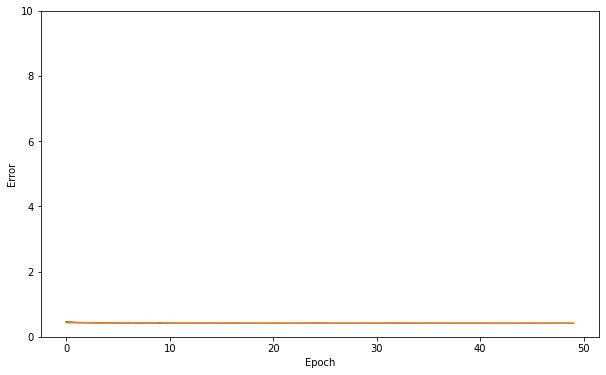

In [357]:
def plot_loss(history2_3B):
  plt.plot(history2_3B.history['loss'], label='loss')
  plt.plot(history2_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_3B)

**MODEL2_3C**

SGD

In [358]:
model2_3C = Sequential()
model2_3C.add(Dense(3, activation='relu', input_dim=(3)))
model2_3C.add(Dense(64, activation='relu' ))
model2_3C.add(Dense(64, activation='relu' ))
model2_3C.add(Dense(64, activation='relu'))
model2_3C.add(Dense(64, activation='relu'))
model2_3C.add(Dense(64, activation='relu'))
model2_3C.add(Dense(32, activation='relu'))
model2_3C.add(Dense(1, name='output'))
model2_3C.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_143 (Dense)           (None, 3)                 12        
                                                                 
 dense_144 (Dense)           (None, 64)                256       
                                                                 
 dense_145 (Dense)           (None, 64)                4160      
                                                                 
 dense_146 (Dense)           (None, 64)                4160      
                                                                 
 dense_147 (Dense)           (None, 64)                4160      
                                                                 
 dense_148 (Dense)           (None, 64)                4160      
                                                                 
 dense_149 (Dense)           (None, 32)              

In [359]:
model2_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [360]:
start_time2_3C = time.time()
history2_3C = model2_3C.fit(x_train2, y_train2, validation_data=(x_val2, y_val2), epochs=50, batch_size=50, verbose=1)
end_time2_3C = time.time()

Epoch 1/50
495/495 [==============================] - 4s 6ms/step - loss: 5.7849 - root_mean_squared_error: 0.4957 - mean_absolute_error: 0.3801 - val_loss: 5.8263 - val_root_mean_squared_error: 0.4983 - val_mean_absolute_error: 0.3827
Epoch 2/50
495/495 [==============================] - 3s 5ms/step - loss: 5.7849 - root_mean_squared_error: 0.4957 - mean_absolute_error: 0.3801 - val_loss: 5.8263 - val_root_mean_squared_error: 0.4983 - val_mean_absolute_error: 0.3827
Epoch 3/50
495/495 [==============================] - 3s 5ms/step - loss: 5.7849 - root_mean_squared_error: 0.4957 - mean_absolute_error: 0.3801 - val_loss: 5.8263 - val_root_mean_squared_error: 0.4983 - val_mean_absolute_error: 0.3827
Epoch 4/50
495/495 [==============================] - 3s 5ms/step - loss: 5.7849 - root_mean_squared_error: 0.4957 - mean_absolute_error: 0.3801 - val_loss: 5.8263 - val_root_mean_squared_error: 0.4983 - val_mean_absolute_error: 0.3827
Epoch 5/50
495/495 [==============================] - 3s

In [361]:
print("--- %s seconds ---" % (end_time2_3C - start_time2_3C))

--- 140.10835123062134 seconds ---


In [362]:
y_pred2_3C = model2_3C.predict(x_test2)
metric2_3C = r2_score(y_test2, y_pred2_3C)
metric2_3C

-1.373204845768547

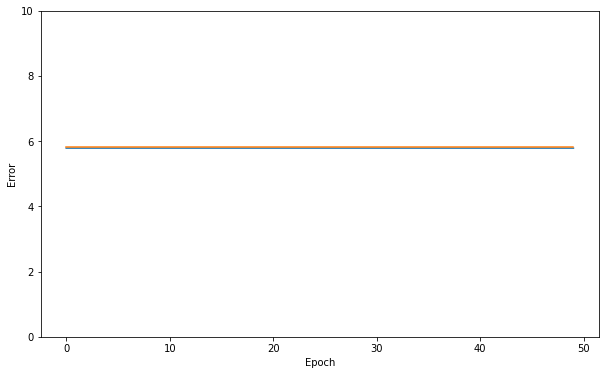

In [363]:
def plot_loss(history2_3C):
  plt.plot(history2_3C.history['loss'], label='loss')
  plt.plot(history2_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history2_3C)

**MODEL3_3A**

adam

In [364]:
model3_3A = Sequential()
model3_3A.add(Dense(3, activation='relu', input_dim=(3)))
model3_3A.add(Dense(64, activation='relu' ))
model3_3A.add(Dense(64, activation='relu' ))
model3_3A.add(Dense(64, activation='relu'))
model3_3A.add(Dense(64, activation='relu'))
model3_3A.add(Dense(64, activation='relu'))
model3_3A.add(Dense(32, activation='relu'))
model3_3A.add(Dense(1, name='output'))
model3_3A.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 3)                 12        
                                                                 
 dense_151 (Dense)           (None, 64)                256       
                                                                 
 dense_152 (Dense)           (None, 64)                4160      
                                                                 
 dense_153 (Dense)           (None, 64)                4160      
                                                                 
 dense_154 (Dense)           (None, 64)                4160      
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dense_156 (Dense)           (None, 32)              

In [365]:
model3_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [366]:
start_time3_3A = time.time()
history3_3A = model3_3A.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_3A = time.time()

Epoch 1/50
496/496 [==============================] - 4s 7ms/step - loss: 1.6597 - root_mean_squared_error: 0.3561 - mean_absolute_error: 0.2513 - val_loss: 0.4982 - val_root_mean_squared_error: 0.1831 - val_mean_absolute_error: 0.1441
Epoch 2/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4511 - root_mean_squared_error: 0.1184 - mean_absolute_error: 0.0916 - val_loss: 0.4290 - val_root_mean_squared_error: 0.0807 - val_mean_absolute_error: 0.0605
Epoch 3/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4256 - root_mean_squared_error: 0.0711 - mean_absolute_error: 0.0517 - val_loss: 0.4231 - val_root_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.0474
Epoch 4/50
496/496 [==============================] - 3s 6ms/step - loss: 0.4197 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0411 - val_loss: 0.4172 - val_root_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.0385
Epoch 5/50
496/496 [==============================] - 3s

In [367]:
print("--- %s seconds ---" % (end_time3_3A - start_time3_3A))

--- 202.761953830719 seconds ---


In [368]:
y_pred3_3A = model3_3A.predict(x_test3)
metric3_3A = r2_score(y_test3, y_pred3_3A)
metric3_3A

0.9905551646924816

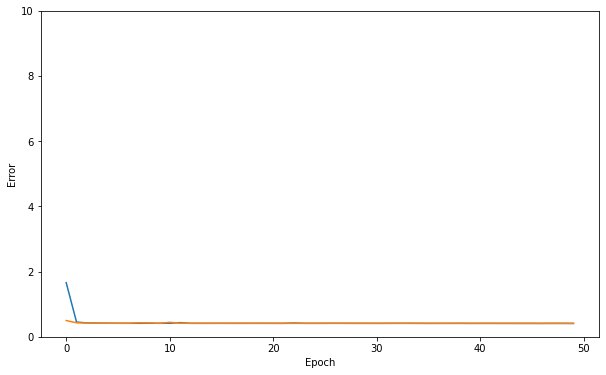

In [369]:
def plot_loss(history3_3A):
  plt.plot(history3_3A.history['loss'], label='loss')
  plt.plot(history3_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_3A)

**MODEL3_3B**

rmsprop

In [370]:
model3_3B = Sequential()
model3_3B.add(Dense(3, activation='relu', input_dim=(3)))
model3_3B.add(Dense(64, activation='relu' ))
model3_3B.add(Dense(64, activation='relu' ))
model3_3B.add(Dense(64, activation='relu'))
model3_3B.add(Dense(64, activation='relu'))
model3_3B.add(Dense(64, activation='relu'))
model3_3B.add(Dense(32, activation='relu'))
model3_3B.add(Dense(1, name='output'))
model3_3B.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_157 (Dense)           (None, 3)                 12        
                                                                 
 dense_158 (Dense)           (None, 64)                256       
                                                                 
 dense_159 (Dense)           (None, 64)                4160      
                                                                 
 dense_160 (Dense)           (None, 64)                4160      
                                                                 
 dense_161 (Dense)           (None, 64)                4160      
                                                                 
 dense_162 (Dense)           (None, 64)                4160      
                                                                 
 dense_163 (Dense)           (None, 32)              

In [371]:
model3_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [372]:
start_time3_3B = time.time()
history3_3B = model3_3B.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_3B = time.time()

Epoch 1/50
496/496 [==============================] - 5s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4673 - mean_absolute_error: 0.3474 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.3442
Epoch 2/50
496/496 [==============================] - 3s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4673 - mean_absolute_error: 0.3474 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.3442
Epoch 3/50
496/496 [==============================] - 4s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4673 - mean_absolute_error: 0.3474 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.3442
Epoch 4/50
496/496 [==============================] - 3s 7ms/step - loss: 5.3154 - root_mean_squared_error: 0.4673 - mean_absolute_error: 0.3474 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4641 - val_mean_absolute_error: 0.3442
Epoch 5/50
496/496 [==============================] - 4s

In [373]:
print("--- %s seconds ---" % (end_time3_3B - start_time3_3B))

--- 203.16280484199524 seconds ---


In [374]:
y_pred3_3B = model3_3B.predict(x_test3)
metric3_3B = r2_score(y_test3, y_pred3_3B)
metric3_3B

-1.2357330262548518

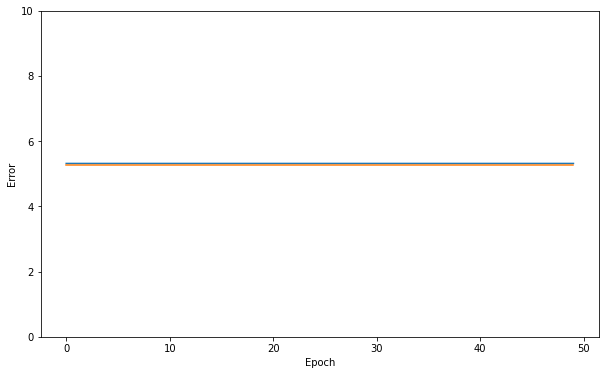

In [375]:
def plot_loss(history3_3B):
  plt.plot(history3_3B.history['loss'], label='loss')
  plt.plot(history3_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_3B)

**MODEL3_3C**

sgd

In [376]:
model3_3C = Sequential()
model3_3C.add(Dense(3, activation='relu', input_dim=(3)))
model3_3C.add(Dense(64, activation='relu' ))
model3_3C.add(Dense(64, activation='relu' ))
model3_3C.add(Dense(64, activation='relu'))
model3_3C.add(Dense(64, activation='relu'))
model3_3C.add(Dense(64, activation='relu'))
model3_3C.add(Dense(32, activation='relu'))
model3_3C.add(Dense(1, name='output'))
model3_3C.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_164 (Dense)           (None, 3)                 12        
                                                                 
 dense_165 (Dense)           (None, 64)                256       
                                                                 
 dense_166 (Dense)           (None, 64)                4160      
                                                                 
 dense_167 (Dense)           (None, 64)                4160      
                                                                 
 dense_168 (Dense)           (None, 64)                4160      
                                                                 
 dense_169 (Dense)           (None, 64)                4160      
                                                                 
 dense_170 (Dense)           (None, 32)              

In [377]:
model3_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [378]:
start_time3_3C = time.time()
history3_3C = model3_3C.fit(x_train3, y_train3, validation_data=(x_val3, y_val3), epochs=50, batch_size=50, verbose=1)
end_time3_3C = time.time()

Epoch 1/50
496/496 [==============================] - 4s 6ms/step - loss: 5.3154 - root_mean_squared_error: 0.4747 - mean_absolute_error: 0.3595 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4714 - val_mean_absolute_error: 0.3563
Epoch 2/50
496/496 [==============================] - 3s 5ms/step - loss: 5.3154 - root_mean_squared_error: 0.4747 - mean_absolute_error: 0.3595 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4714 - val_mean_absolute_error: 0.3563
Epoch 3/50
496/496 [==============================] - 3s 5ms/step - loss: 5.3154 - root_mean_squared_error: 0.4747 - mean_absolute_error: 0.3595 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4714 - val_mean_absolute_error: 0.3563
Epoch 4/50
496/496 [==============================] - 3s 5ms/step - loss: 5.3154 - root_mean_squared_error: 0.4747 - mean_absolute_error: 0.3595 - val_loss: 5.2658 - val_root_mean_squared_error: 0.4714 - val_mean_absolute_error: 0.3563
Epoch 5/50
496/496 [==============================] - 3s

In [379]:
print("--- %s seconds ---" % (end_time3_3C - start_time3_3C))

--- 137.38389682769775 seconds ---


In [380]:
y_pred3_3C = model3_3C.predict(x_test3)
metric3_3C = r2_score(y_test3, y_pred3_3C)
metric3_3C

-1.3049494039391871

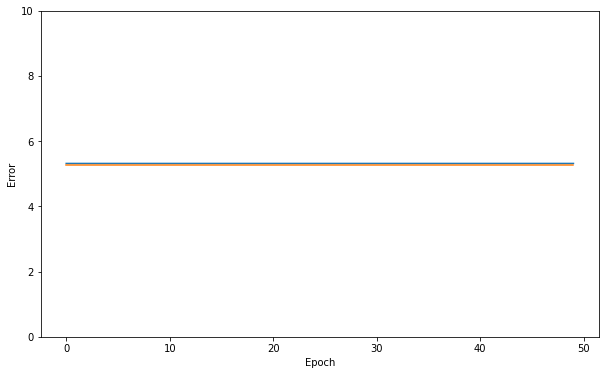

In [381]:
def plot_loss(history3_3C):
  plt.plot(history3_3C.history['loss'], label='loss')
  plt.plot(history3_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history3_3C)

**MODEL4_3A**

adam

In [382]:
model4_3A = Sequential()
model4_3A.add(Dense(3, activation='relu', input_dim=(3)))
model4_3A.add(Dense(64, activation='relu' ))
model4_3A.add(Dense(64, activation='relu' ))
model4_3A.add(Dense(64, activation='relu'))
model4_3A.add(Dense(64, activation='relu'))
model4_3A.add(Dense(64, activation='relu'))
model4_3A.add(Dense(32, activation='relu'))
model4_3A.add(Dense(1, name='output'))
model4_3A.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_171 (Dense)           (None, 3)                 12        
                                                                 
 dense_172 (Dense)           (None, 64)                256       
                                                                 
 dense_173 (Dense)           (None, 64)                4160      
                                                                 
 dense_174 (Dense)           (None, 64)                4160      
                                                                 
 dense_175 (Dense)           (None, 64)                4160      
                                                                 
 dense_176 (Dense)           (None, 64)                4160      
                                                                 
 dense_177 (Dense)           (None, 32)              

In [383]:
model4_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [384]:
start_time4_3A = time.time()
history4_3A = model4_3A.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_3A = time.time()

Epoch 1/50
447/447 [==============================] - 3s 6ms/step - loss: 0.8867 - root_mean_squared_error: 0.4021 - mean_absolute_error: 0.3123 - val_loss: 0.5406 - val_root_mean_squared_error: 0.2343 - val_mean_absolute_error: 0.2060
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4591 - root_mean_squared_error: 0.1455 - mean_absolute_error: 0.1083 - val_loss: 0.4198 - val_root_mean_squared_error: 0.0803 - val_mean_absolute_error: 0.0575
Epoch 3/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4151 - root_mean_squared_error: 0.0791 - mean_absolute_error: 0.0535 - val_loss: 0.4102 - val_root_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.0470
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 0.4107 - root_mean_squared_error: 0.0679 - mean_absolute_error: 0.0456 - val_loss: 0.4681 - val_root_mean_squared_error: 0.1572 - val_mean_absolute_error: 0.1176
Epoch 5/50
447/447 [==============================] - 2s

In [385]:
print("--- %s seconds ---" % (end_time4_3A - start_time4_3A))

--- 142.75391697883606 seconds ---


In [386]:
y_pred4_3A = model4_3A.predict(x_test4)
metric4_3A = r2_score(y_test4, y_pred4_3A)
metric4_3A

0.9962467923517418

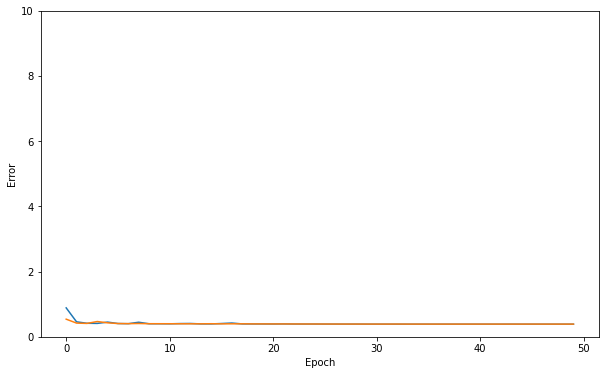

In [387]:
def plot_loss(history4_3A):
  plt.plot(history4_3A.history['loss'], label='loss')
  plt.plot(history4_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_3A)

**MODEL4_3B**

rmsprop

In [388]:
model4_3B = Sequential()
model4_3B.add(Dense(3, activation='relu', input_dim=(3)))
model4_3B.add(Dense(64, activation='relu' ))
model4_3B.add(Dense(64, activation='relu' ))
model4_3B.add(Dense(64, activation='relu'))
model4_3B.add(Dense(64, activation='relu'))
model4_3B.add(Dense(64, activation='relu'))
model4_3B.add(Dense(32, activation='relu'))
model4_3B.add(Dense(1, name='output'))
model4_3B.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_178 (Dense)           (None, 3)                 12        
                                                                 
 dense_179 (Dense)           (None, 64)                256       
                                                                 
 dense_180 (Dense)           (None, 64)                4160      
                                                                 
 dense_181 (Dense)           (None, 64)                4160      
                                                                 
 dense_182 (Dense)           (None, 64)                4160      
                                                                 
 dense_183 (Dense)           (None, 64)                4160      
                                                                 
 dense_184 (Dense)           (None, 32)              

In [389]:
model4_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [390]:
start_time4_3B = time.time()
history4_3B = model4_3B.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_3B = time.time()

Epoch 1/50
447/447 [==============================] - 5s 8ms/step - loss: 0.4652 - root_mean_squared_error: 0.1647 - mean_absolute_error: 0.1096 - val_loss: 0.4165 - val_root_mean_squared_error: 0.0859 - val_mean_absolute_error: 0.0560
Epoch 2/50
447/447 [==============================] - 3s 6ms/step - loss: 0.4214 - root_mean_squared_error: 0.0980 - mean_absolute_error: 0.0635 - val_loss: 0.4148 - val_root_mean_squared_error: 0.0793 - val_mean_absolute_error: 0.0445
Epoch 3/50
447/447 [==============================] - 3s 7ms/step - loss: 0.4181 - root_mean_squared_error: 0.0876 - mean_absolute_error: 0.0557 - val_loss: 0.4215 - val_root_mean_squared_error: 0.0829 - val_mean_absolute_error: 0.0694
Epoch 4/50
447/447 [==============================] - 3s 6ms/step - loss: 0.4109 - root_mean_squared_error: 0.0704 - mean_absolute_error: 0.0472 - val_loss: 0.4168 - val_root_mean_squared_error: 0.0864 - val_mean_absolute_error: 0.0542
Epoch 5/50
447/447 [==============================] - 3s

In [391]:
print("--- %s seconds ---" % (end_time4_3B - start_time4_3B))

--- 151.88806772232056 seconds ---


In [392]:
y_pred4_3B = model4_3B.predict(x_test4)
metric4_3B = r2_score(y_test4, y_pred4_3B)
metric4_3B

0.9871068237872511

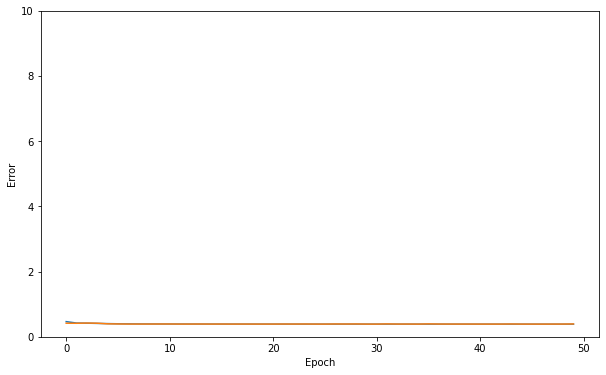

In [393]:
def plot_loss(history4_3B):
  plt.plot(history4_3B.history['loss'], label='loss')
  plt.plot(history4_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_3B)

**MODEL4_3C**

sgd

In [394]:
model4_3C = Sequential()
model4_3C.add(Dense(3, activation='relu', input_dim=(3)))
model4_3C.add(Dense(64, activation='relu' ))
model4_3C.add(Dense(64, activation='relu' ))
model4_3C.add(Dense(64, activation='relu'))
model4_3C.add(Dense(64, activation='relu'))
model4_3C.add(Dense(64, activation='relu'))
model4_3C.add(Dense(32, activation='relu'))
model4_3C.add(Dense(1, name='output'))
model4_3C.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_185 (Dense)           (None, 3)                 12        
                                                                 
 dense_186 (Dense)           (None, 64)                256       
                                                                 
 dense_187 (Dense)           (None, 64)                4160      
                                                                 
 dense_188 (Dense)           (None, 64)                4160      
                                                                 
 dense_189 (Dense)           (None, 64)                4160      
                                                                 
 dense_190 (Dense)           (None, 64)                4160      
                                                                 
 dense_191 (Dense)           (None, 32)              

In [395]:
model4_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [396]:
start_time4_3C = time.time()
history4_3C = model4_3C.fit(x_train4, y_train4, validation_data=(x_val4, y_val4), epochs=50, batch_size=50, verbose=1)
end_time4_3C = time.time()

Epoch 1/50
447/447 [==============================] - 3s 6ms/step - loss: 8.8079 - root_mean_squared_error: 37.5141 - mean_absolute_error: 37.4709 - val_loss: 8.8138 - val_root_mean_squared_error: 37.5541 - val_mean_absolute_error: 37.5521
Epoch 2/50
447/447 [==============================] - 2s 5ms/step - loss: 8.8226 - root_mean_squared_error: 37.5563 - mean_absolute_error: 37.5542 - val_loss: 8.8138 - val_root_mean_squared_error: 37.5541 - val_mean_absolute_error: 37.5521
Epoch 3/50
447/447 [==============================] - 3s 6ms/step - loss: 8.8226 - root_mean_squared_error: 37.5563 - mean_absolute_error: 37.5542 - val_loss: 8.8138 - val_root_mean_squared_error: 37.5541 - val_mean_absolute_error: 37.5521
Epoch 4/50
447/447 [==============================] - 2s 5ms/step - loss: 8.8226 - root_mean_squared_error: 37.5563 - mean_absolute_error: 37.5542 - val_loss: 8.8138 - val_root_mean_squared_error: 37.5541 - val_mean_absolute_error: 37.5521
Epoch 5/50
447/447 [====================

In [397]:
print("--- %s seconds ---" % (end_time4_3C - start_time4_3C))

--- 122.13276672363281 seconds ---


In [398]:
y_pred4_3C = model4_3C.predict(x_test4)
metric4_3C = r2_score(y_test4, y_pred4_3C)
metric4_3C

-11680.983435366408

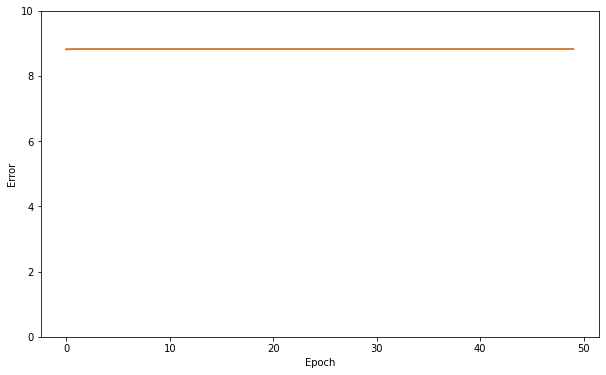

In [399]:
def plot_loss(history4_3C):
  plt.plot(history4_3C.history['loss'], label='loss')
  plt.plot(history4_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history4_3C)

**MODEL5_3A**

adam

In [400]:
model5_3A = Sequential()
model5_3A.add(Dense(3, activation='relu', input_dim=(3)))
model5_3A.add(Dense(64, activation='relu' ))
model5_3A.add(Dense(64, activation='relu' ))
model5_3A.add(Dense(64, activation='relu'))
model5_3A.add(Dense(64, activation='relu'))
model5_3A.add(Dense(64, activation='relu'))
model5_3A.add(Dense(32, activation='relu'))
model5_3A.add(Dense(1, name='output'))
model5_3A.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 3)                 12        
                                                                 
 dense_193 (Dense)           (None, 64)                256       
                                                                 
 dense_194 (Dense)           (None, 64)                4160      
                                                                 
 dense_195 (Dense)           (None, 64)                4160      
                                                                 
 dense_196 (Dense)           (None, 64)                4160      
                                                                 
 dense_197 (Dense)           (None, 64)                4160      
                                                                 
 dense_198 (Dense)           (None, 32)              

In [401]:
model5_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [402]:
start_time5_3A = time.time()
history5_3A = model5_3A.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_3A = time.time()

Epoch 1/50
424/424 [==============================] - 4s 7ms/step - loss: 0.7354 - root_mean_squared_error: 0.3451 - mean_absolute_error: 0.2624 - val_loss: 0.6053 - val_root_mean_squared_error: 0.2927 - val_mean_absolute_error: 0.2529
Epoch 2/50
424/424 [==============================] - 3s 6ms/step - loss: 0.5799 - root_mean_squared_error: 0.2727 - mean_absolute_error: 0.2307 - val_loss: 0.5529 - val_root_mean_squared_error: 0.2508 - val_mean_absolute_error: 0.2128
Epoch 3/50
424/424 [==============================] - 2s 5ms/step - loss: 0.5114 - root_mean_squared_error: 0.2125 - mean_absolute_error: 0.1694 - val_loss: 0.4937 - val_root_mean_squared_error: 0.1937 - val_mean_absolute_error: 0.1479
Epoch 4/50
424/424 [==============================] - 3s 6ms/step - loss: 0.4882 - root_mean_squared_error: 0.1900 - mean_absolute_error: 0.1445 - val_loss: 0.4786 - val_root_mean_squared_error: 0.1806 - val_mean_absolute_error: 0.1331
Epoch 5/50
424/424 [==============================] - 2s

In [403]:
print("--- %s seconds ---" % (end_time5_3A - start_time5_3A))

--- 142.7309010028839 seconds ---


In [404]:
y_pred5_3A = model5_3A.predict(x_test5)
metric5_3A = r2_score(y_test5, y_pred5_3A)
metric5_3A

0.9825527551304741

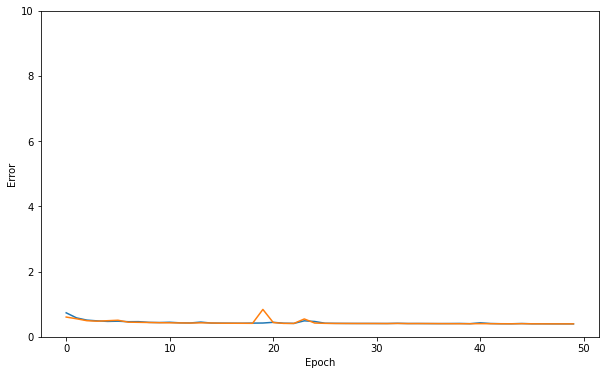

In [405]:
def plot_loss(history5_3A):
  plt.plot(history5_3A.history['loss'], label='loss')
  plt.plot(history5_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_3A)

**MODEL5_3B**

rmsprop

In [406]:
model5_3B = Sequential()
model5_3B.add(Dense(3, activation='relu', input_dim=(3)))
model5_3B.add(Dense(64, activation='relu' ))
model5_3B.add(Dense(64, activation='relu' ))
model5_3B.add(Dense(64, activation='relu'))
model5_3B.add(Dense(64, activation='relu'))
model5_3B.add(Dense(64, activation='relu'))
model5_3B.add(Dense(32, activation='relu'))
model5_3B.add(Dense(1, name='output'))
model5_3B.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 3)                 12        
                                                                 
 dense_200 (Dense)           (None, 64)                256       
                                                                 
 dense_201 (Dense)           (None, 64)                4160      
                                                                 
 dense_202 (Dense)           (None, 64)                4160      
                                                                 
 dense_203 (Dense)           (None, 64)                4160      
                                                                 
 dense_204 (Dense)           (None, 64)                4160      
                                                                 
 dense_205 (Dense)           (None, 32)              

In [407]:
model5_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [408]:
start_time5_3B = time.time()
history5_3B = model5_3B.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_3B = time.time()

Epoch 1/50
424/424 [==============================] - 4s 7ms/step - loss: 0.4389 - root_mean_squared_error: 0.1102 - mean_absolute_error: 0.0614 - val_loss: 0.4162 - val_root_mean_squared_error: 0.0944 - val_mean_absolute_error: 0.0592
Epoch 2/50
424/424 [==============================] - 3s 7ms/step - loss: 0.4083 - root_mean_squared_error: 0.0663 - mean_absolute_error: 0.0410 - val_loss: 0.4001 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.0343
Epoch 3/50
424/424 [==============================] - 3s 7ms/step - loss: 0.4030 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0349 - val_loss: 0.3980 - val_root_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.0380
Epoch 4/50
424/424 [==============================] - 3s 7ms/step - loss: 0.4007 - root_mean_squared_error: 0.0468 - mean_absolute_error: 0.0312 - val_loss: 0.3952 - val_root_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.0221
Epoch 5/50
424/424 [==============================] - 3s

In [409]:
print("--- %s seconds ---" % (end_time5_3B - start_time5_3B))

--- 203.15525269508362 seconds ---


In [410]:
y_pred5_3B = model5_3B.predict(x_test5)
metric5_3B = r2_score(y_test5, y_pred5_3B)
metric5_3B

0.9952639808893927

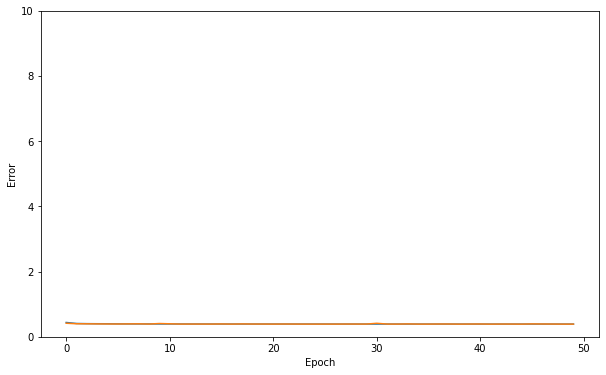

In [411]:
def plot_loss(history5_3B):
  plt.plot(history5_3B.history['loss'], label='loss')
  plt.plot(history5_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_3B)

**MODEL5_3C**

sgd

In [412]:
model5_3C = Sequential()
model5_3C.add(Dense(3, activation='relu', input_dim=(3)))
model5_3C.add(Dense(64, activation='relu' ))
model5_3C.add(Dense(64, activation='relu' ))
model5_3C.add(Dense(64, activation='relu'))
model5_3C.add(Dense(64, activation='relu'))
model5_3C.add(Dense(64, activation='relu'))
model5_3C.add(Dense(32, activation='relu'))
model5_3C.add(Dense(1, name='output'))
model5_3C.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_206 (Dense)           (None, 3)                 12        
                                                                 
 dense_207 (Dense)           (None, 64)                256       
                                                                 
 dense_208 (Dense)           (None, 64)                4160      
                                                                 
 dense_209 (Dense)           (None, 64)                4160      
                                                                 
 dense_210 (Dense)           (None, 64)                4160      
                                                                 
 dense_211 (Dense)           (None, 64)                4160      
                                                                 
 dense_212 (Dense)           (None, 32)              

In [413]:
model5_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [414]:
start_time5_3C = time.time()
history5_3C = model5_3C.fit(x_train5, y_train5, validation_data=(x_val5, y_val5), epochs=50, batch_size=50, verbose=1)
end_time5_3C = time.time()

Epoch 1/50
424/424 [==============================] - 3s 7ms/step - loss: 4.7855 - root_mean_squared_error: 0.4763 - mean_absolute_error: 0.3564 - val_loss: 0.6347 - val_root_mean_squared_error: 0.3152 - val_mean_absolute_error: 0.2704
Epoch 2/50
424/424 [==============================] - 3s 6ms/step - loss: 0.5617 - root_mean_squared_error: 0.2511 - mean_absolute_error: 0.2052 - val_loss: 0.4219 - val_root_mean_squared_error: 0.1015 - val_mean_absolute_error: 0.0790
Epoch 3/50
424/424 [==============================] - 2s 5ms/step - loss: 0.4208 - root_mean_squared_error: 0.0888 - mean_absolute_error: 0.0551 - val_loss: 0.3994 - val_root_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.0281
Epoch 4/50
424/424 [==============================] - 2s 5ms/step - loss: 3.9897 - root_mean_squared_error: 0.4778 - mean_absolute_error: 0.3361 - val_loss: 5.6524 - val_root_mean_squared_error: 0.5793 - val_mean_absolute_error: 0.4745
Epoch 5/50
424/424 [==============================] - 3s

In [415]:
print("--- %s seconds ---" % (end_time5_3C - start_time5_3C))

--- 120.36089134216309 seconds ---


In [416]:
y_pred5_3C = model5_3C.predict(x_test5)
metric5_3C = r2_score(y_test5, y_pred5_3C)
metric5_3C

-1.9906284411940707

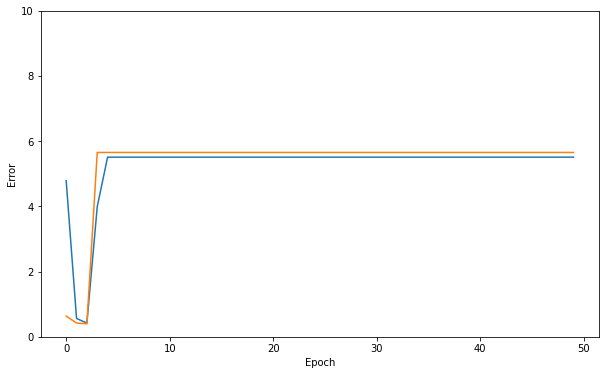

In [417]:
def plot_loss(history5_3C):
  plt.plot(history5_3C.history['loss'], label='loss')
  plt.plot(history5_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history5_3C)

**MODEL6_3A**

adam

In [418]:
model6_3A = Sequential()
model6_3A.add(Dense(3, activation='relu', input_dim=(3)))
model6_3A.add(Dense(64, activation='relu' ))
model6_3A.add(Dense(64, activation='relu' ))
model6_3A.add(Dense(64, activation='relu'))
model6_3A.add(Dense(64, activation='relu'))
model6_3A.add(Dense(64, activation='relu'))
model6_3A.add(Dense(32, activation='relu'))
model6_3A.add(Dense(1, name='output'))
model6_3A.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 3)                 12        
                                                                 
 dense_214 (Dense)           (None, 64)                256       
                                                                 
 dense_215 (Dense)           (None, 64)                4160      
                                                                 
 dense_216 (Dense)           (None, 64)                4160      
                                                                 
 dense_217 (Dense)           (None, 64)                4160      
                                                                 
 dense_218 (Dense)           (None, 64)                4160      
                                                                 
 dense_219 (Dense)           (None, 32)              

In [419]:
model6_3A.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [420]:
start_time6_3A = time.time()
history6_3A = model6_3A.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_3A = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 0.5396 - root_mean_squared_error: 0.2348 - mean_absolute_error: 0.1463 - val_loss: 0.4003 - val_root_mean_squared_error: 0.0636 - val_mean_absolute_error: 0.0418
Epoch 2/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3990 - root_mean_squared_error: 0.0599 - mean_absolute_error: 0.0405 - val_loss: 0.3962 - val_root_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.0328
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3951 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0324 - val_loss: 0.3951 - val_root_mean_squared_error: 0.0490 - val_mean_absolute_error: 0.0308
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 0.3983 - root_mean_squared_error: 0.0608 - mean_absolute_error: 0.0386 - val_loss: 0.3957 - val_root_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.0301
Epoch 5/50
454/454 [==============================] - 3s

In [421]:
print("--- %s seconds ---" % (end_time6_3A - start_time6_3A))

--- 142.7378363609314 seconds ---


In [422]:
y_pred6_3A = model6_3A.predict(x_test6)
metric6_3A = r2_score(y_test6, y_pred6_3A)
metric6_3A

0.9952619144753972

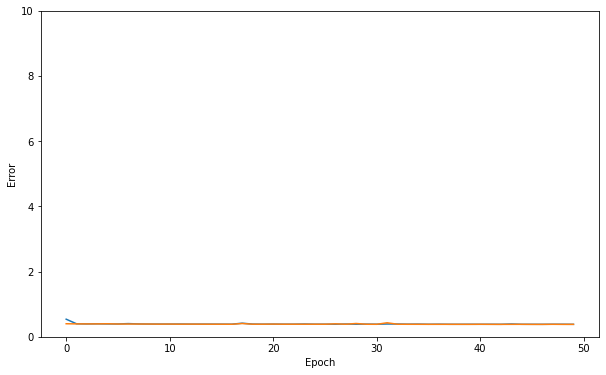

In [423]:
def plot_loss(history6_3A):
  plt.plot(history6_3A.history['loss'], label='loss')
  plt.plot(history6_3A.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_3A)

**MODEL6_3B**

rmsprop

In [424]:
model6_3B = Sequential()
model6_3B.add(Dense(3, activation='relu', input_dim=(3)))
model6_3B.add(Dense(64, activation='relu' ))
model6_3B.add(Dense(64, activation='relu' ))
model6_3B.add(Dense(64, activation='relu'))
model6_3B.add(Dense(64, activation='relu'))
model6_3B.add(Dense(64, activation='relu'))
model6_3B.add(Dense(32, activation='relu'))
model6_3B.add(Dense(1, name='output'))
model6_3B.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_220 (Dense)           (None, 3)                 12        
                                                                 
 dense_221 (Dense)           (None, 64)                256       
                                                                 
 dense_222 (Dense)           (None, 64)                4160      
                                                                 
 dense_223 (Dense)           (None, 64)                4160      
                                                                 
 dense_224 (Dense)           (None, 64)                4160      
                                                                 
 dense_225 (Dense)           (None, 64)                4160      
                                                                 
 dense_226 (Dense)           (None, 32)              

In [425]:
model6_3B.compile(optimizer='rmsprop',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [426]:
start_time6_3B = time.time()
history6_3B = model6_3B.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_3B = time.time()

Epoch 1/50
454/454 [==============================] - 4s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5433 - mean_absolute_error: 0.4156 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5454 - val_mean_absolute_error: 0.4173
Epoch 2/50
454/454 [==============================] - 3s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5433 - mean_absolute_error: 0.4156 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5454 - val_mean_absolute_error: 0.4173
Epoch 3/50
454/454 [==============================] - 3s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5433 - mean_absolute_error: 0.4156 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5454 - val_mean_absolute_error: 0.4173
Epoch 4/50
454/454 [==============================] - 3s 7ms/step - loss: 6.4066 - root_mean_squared_error: 0.5433 - mean_absolute_error: 0.4156 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5454 - val_mean_absolute_error: 0.4173
Epoch 5/50
454/454 [==============================] - 3s

In [427]:
print("--- %s seconds ---" % (end_time6_3B - start_time6_3B))

--- 203.11897158622742 seconds ---


In [428]:
y_pred6_3B = model6_3B.predict(x_test6)
metric6_3B = r2_score(y_test6, y_pred6_3B)
metric6_3B

-1.4034756759089442

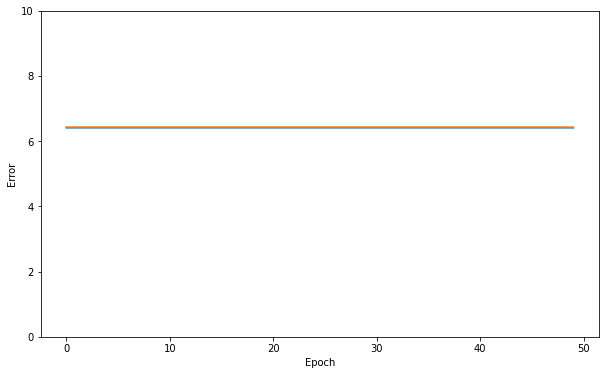

In [429]:
def plot_loss(history6_3B):
  plt.plot(history6_3B.history['loss'], label='loss')
  plt.plot(history6_3B.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_3B)

**MODEL6_3C**

sgd

In [430]:
model6_3C = Sequential()
model6_3C.add(Dense(3, activation='relu', input_dim=(3)))
model6_3C.add(Dense(64, activation='relu' ))
model6_3C.add(Dense(64, activation='relu' ))
model6_3C.add(Dense(64, activation='relu'))
model6_3C.add(Dense(64, activation='relu'))
model6_3C.add(Dense(64, activation='relu'))
model6_3C.add(Dense(32, activation='relu'))
model6_3C.add(Dense(1, name='output'))
model6_3C.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_227 (Dense)           (None, 3)                 12        
                                                                 
 dense_228 (Dense)           (None, 64)                256       
                                                                 
 dense_229 (Dense)           (None, 64)                4160      
                                                                 
 dense_230 (Dense)           (None, 64)                4160      
                                                                 
 dense_231 (Dense)           (None, 64)                4160      
                                                                 
 dense_232 (Dense)           (None, 64)                4160      
                                                                 
 dense_233 (Dense)           (None, 32)              

In [431]:
model6_3C.compile(optimizer='sgd',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [432]:
start_time6_3C = time.time()
history6_3C = model6_3C.fit(x_train6, y_train6, validation_data=(x_val6, y_val6), epochs=50, batch_size=50, verbose=1)
end_time6_3C = time.time()

Epoch 1/50
454/454 [==============================] - 3s 6ms/step - loss: 6.4066 - root_mean_squared_error: 0.5455 - mean_absolute_error: 0.4193 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5476 - val_mean_absolute_error: 0.4210
Epoch 2/50
454/454 [==============================] - 2s 5ms/step - loss: 6.4066 - root_mean_squared_error: 0.5455 - mean_absolute_error: 0.4193 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5476 - val_mean_absolute_error: 0.4210
Epoch 3/50
454/454 [==============================] - 2s 5ms/step - loss: 6.4066 - root_mean_squared_error: 0.5455 - mean_absolute_error: 0.4193 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5476 - val_mean_absolute_error: 0.4210
Epoch 4/50
454/454 [==============================] - 2s 5ms/step - loss: 6.4066 - root_mean_squared_error: 0.5455 - mean_absolute_error: 0.4193 - val_loss: 6.4333 - val_root_mean_squared_error: 0.5476 - val_mean_absolute_error: 0.4210
Epoch 5/50
454/454 [==============================] - 2s

In [433]:
print("--- %s seconds ---" % (end_time6_3C - start_time6_3C))

--- 125.83932423591614 seconds ---


In [434]:
y_pred6_3C = model6_3C.predict(x_test6)
metric6_3C = r2_score(y_test6, y_pred6_3C)
metric6_3C

-1.4233490249434881

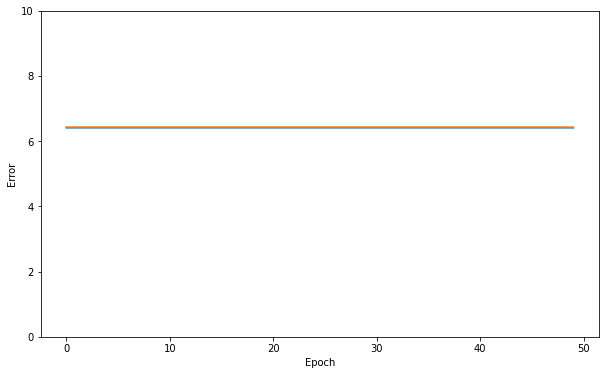

In [435]:
def plot_loss(history6_3C):
  plt.plot(history6_3C.history['loss'], label='loss')
  plt.plot(history6_3C.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(history6_3C)